# Springboard - Data Science Career Track

# Capstone Project I: Kiva.org loan delays

In [1]:
# link for the data
kiva_url = "https://www.kaggle.com/lucian18/mpi-on-regions#all_kiva_loans.csv"

### Goal of the project:
    
**Understand what may cause a higher delay between:**

-  the "posted time" (the time at which the loan is posted on Kiva by the field agent)
-  the "funded time" (the time at which the loan posted to Kiva gets 100% funded by lenders)
- the "disbursed time" (the time at which the loan is disbursed by the field agent to the borrower)

#### **The journey of a Kiva loan**

- A borrower applies for a loan.
- The loan goes through the underwriting and approval process
- If it is approved, the loan disbursal period starts
    - The loan is posted to Kiva for lenders to support
    - Fundraising period
    - Fundraising complete (or not)
- Borrower repays the loan
- Lenders use repayments to fund new loans, donate or withdraw the money.

Partner loans are administered by Kiva’s Field Partners and are available to borrowers in more than 80 countries. Direct loans are made using the digital payment system and don’t involve a Field Partner.

**Note**: *Disbursal* refers to when the borrower can access the money, but the timing of it can vary:    
  - For most Field Partner loans, the money is *pre-disbursed* (when partners give the funds out before the loan is posted), so the borrower can access the funds right away. 
  - For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

### Libraries

In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore, normaltest, shapiro, norm, t
from collections import Counter
sns.set()
from scipy import stats
import scipy
import statsmodels.api as sm

## 1) Data inspection and Cleaning

In [3]:
# filename
kiva_data = pd.read_csv("all_kiva_loans_copy.csv")

### Overview and cleaning

In [4]:
kiva_data.head(3)

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
0,657307,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,...,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,female,irregular
1,657259,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",...,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,female,monthly
2,658010,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,...,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,female,monthly


In [5]:
kiva_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1419607 non-null int64
funded_amount              1419607 non-null float64
loan_amount                1419607 non-null float64
status                     1419607 non-null object
activity_name              1419607 non-null object
sector_name                1419607 non-null object
loan_use                   1376334 non-null object
country_code               1419598 non-null object
country_name               1419607 non-null object
town_name                  1257849 non-null object
currency_policy            1419607 non-null object
currency                   1419607 non-null object
partner_id                 1402817 non-null float64
posted_time                1419607 non-null object
planned_expiration_time    1047773 non-null object
disburse_time              1416794 non-null object
raised_time                1355325 non-null object
lender_term       

#### Changing dtpes and labels

In [6]:
# Changing some column names, for clarity
kiva_data.rename(columns={'disburse_time':'disbursed_time', 'raised_time':'funded_time'}, inplace=True)

In [7]:
# change the dtype of the main variables of study to datetime64[ns]
kiva_data['posted_time'] = pd.to_datetime(kiva_data['posted_time'], errors='coerce')
kiva_data['planned_expiration_time'] = pd.to_datetime(kiva_data['planned_expiration_time'], errors='coerce')
kiva_data['disbursed_time'] = pd.to_datetime(kiva_data['disbursed_time'], errors='coerce')
kiva_data['funded_time'] = pd.to_datetime(kiva_data['funded_time'], errors='coerce')

### Main variables inspection and cleaning

#### 1) 'posted_time'

In [8]:
# As seen above, there are no missing values and the filled ones seem to be ok
kiva_data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419607,1416794,1355325
unique,1415162,75668,1137793
top,2006-04-16 07:10:50,2017-02-01 08:00:00,2005-03-31 06:27:55
freq,207,2800,203
first,2006-04-16 07:10:50,2005-04-14 05:27:55,2005-03-31 06:27:55
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


In [9]:
# checking frequency
kiva_data['posted_time'].value_counts().head()

2006-04-16 07:10:50    207
2015-05-27 08:05:17      3
2008-02-12 22:15:45      3
2015-03-12 08:01:30      3
2016-04-26 08:08:20      3
Name: posted_time, dtype: int64

Apparently the 'posted_time' column is clean

#### 2) 'funded_time'

In [10]:
# filled and missing values
kiva_data['funded_time'].isna().value_counts()

False    1355325
True       64282
Name: funded_time, dtype: int64

- Regarding the **missing values**, even though some null-values might correspond to loans which were indeed funded (as seen in the example below), there is not a way to know how to fill those values, and I will not consider the following ones for analysis, so that there is no ambiguity. 

In [11]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0

missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# Note: I considered ok when the funded_amount was larger than the loan_amount, hence the <

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
142677,849172,700.0,700.0,expired,Cereals,Food,to buy maize to sell.,UG,Uganda,Hoima,...,UGX,163.0,2015-03-02 13:07:56,2015-04-06 12:20:02,2015-02-18 08:00:00,NaT,12.0,25,male,monthly
508508,985199,3400.0,3000.0,expired,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",...,USD,169.0,2015-11-25 10:53:00,2015-12-28 19:20:08,2015-10-29 07:00:00,NaT,38.0,84,male,monthly
628009,114629,125.0,125.0,refunded,Retail,Retail,NaN,PH,Philippines,NaN,...,PHP,128.0,2009-06-11 01:27:29,NaT,2009-05-29 07:00:00,NaT,12.0,5,NaN,irregular
657411,38915,1475.0,1475.0,expired,Food Market,Food,To expand fresh food business,UG,Uganda,Nansana,...,UGX,65.0,2008-02-28 07:10:56,NaT,2008-07-22 07:00:00,NaT,NaN,24,"female, female, female, female, female",irregular
809473,924149,425.0,400.0,expired,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",...,MZN,23.0,2015-07-28 07:14:04,2015-09-09 18:30:02,2015-07-22 07:00:00,NaT,17.0,11,male,monthly
861839,147,1000.0,1000.0,refunded,Farming,Agriculture,NaN,BG,Bulgaria,NaN,...,USD,3.0,2006-04-16 07:10:50,NaT,2006-03-15 05:00:00,NaT,6.0,16,NaN,bullet
1368801,408534,1275.0,1275.0,expired,Agriculture,Agriculture,To buy the inventory for his fruit and vegetab...,AZ,Azerbaijan,NaN,...,AZN,207.0,2012-03-24 13:05:34,2012-05-02 15:00:03,2012-03-07 08:00:00,NaT,20.0,44,female,monthly


The remaining missing values will be kept due to several reasons. Not every loan is funded, or when there is a filled value in funded_amount, because the loan may not be completely funded yet, that is, the funded_amount is smaller than the loan_amount.

- Regarding the **filled values**, there are 2 columns with which we can compare to check if there are discrepancies:

    - funded_amount and status

*'funded_time' vs 'funded_amount'*

In [12]:
# Comparing with the funded_amount column, there are no discrepancies
kiva_data[(kiva_data['funded_time'].notnull()) & (kiva_data['funded_amount'] > 0)].count()[['funded_time', 'funded_amount']]

funded_time      1355325
funded_amount    1355325
dtype: int64

In [13]:
# However, when looking at the difference between loan_amount and funded_amount, we notice inconsistency in the data
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0] 

# Note: the funded_time is only filled when the loan is 100% funded by lenders

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
60715,57210,925.0,950.0,funded,Clothing,Clothing,Increase business capital,RW,Rwanda,Gasabo/Buliza/Rwanda,...,RWF,117.0,2008-07-17 15:59:58,NaT,2008-08-05 07:00:00,2008-07-22 18:26:42,14.0,35,female,monthly
233811,44276,475.0,500.0,funded,Food Production/Sales,Food,NaN,KE,Kenya,NaN,...,KES,36.0,2008-04-08 13:26:42,NaT,2008-05-03 05:39:35,2008-04-19 05:39:35,14.0,14,NaN,monthly
518536,48958,25.0,950.0,refunded,Food Production/Sales,Food,NaN,SN,Senegal,NaN,...,XOF,105.0,2008-05-15 16:09:47,NaT,2008-05-31 07:00:00,2008-05-17 22:33:56,8.0,1,NaN,monthly
577064,745,125.0,1000.0,refunded,Sewing,Services,NaN,KH,Cambodia,NaN,...,USD,9.0,2006-08-18 09:12:23,NaT,2006-09-11 02:34:47,2006-08-28 02:34:47,21.0,4,NaN,monthly


Therefore, I will not consider these rows too, so the data is clear.

*'funded_time' vs 'status'*

In [14]:
# Comparing with the status column:

# datetime and status columns described
kiva_data[['posted_time', 'funded_time', 'status']].describe()

,posted_time,funded_time,status
count,1419607,1355325,1419607
unique,1415162,1137793,4
top,2006-04-16 07:10:50,2005-03-31 06:27:55,funded
freq,207,203,1350340
first,2006-04-16 07:10:50,2005-03-31 06:27:55,NaN
last,2018-01-11 07:11:23,2018-01-11 03:11:44,NaN


In [15]:
# status column variables
kiva_data['status'].value_counts()

funded         1350340
expired          59081
refunded          6578
fundRaising       3608
Name: status, dtype: int64

In [16]:
# comparing funded_time non nulls with 'status':funded

kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    1350340
status         1350340
dtype: int64

Whenever the loan is described as 'funded', a corresponding value appears in the 'funded_time' column.

In [17]:
# comparing funded_time non nulls with 'status' = refunded

kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    4983
status         4983
dtype: int64

Whenever the loan is described as 'refunded', a corresponding value appears in the 'funded_time' column.

We can see that the sum of the rows where the status is indicated as 'funded' with the ones where it is indicated as 'refunded' has less 2 values than the total number of 'funded_time' values

In [18]:
# funded_time non nulls with 'status':funded
ft_f = kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count().status 

# funded_time non nulls with 'status' = refunded
ft_ref = kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count().status

# funded_time total non nulls
ft_tot = kiva_data['funded_time'].count()

ft_tot - (ft_f + ft_ref)

2

In [19]:
# comparing funded_time non nulls with 'status' = expired

kiva_data[(kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
926652,601656,925.0,925.0,expired,Home Products Sales,Retail,to purchase clothing and household items for r...,GE,Georgia,Vani,...,GEL,181.0,2013-08-29 13:43:33,2013-10-03 15:10:02,2013-07-31 07:00:00,2013-10-03 15:16:01,15.0,29,female,monthly
1144537,149173,4600.0,4600.0,expired,Retail,Retail,Increase working capital,BO,Bolivia,NaN,...,BOB,73.0,2009-10-30 20:19:53,NaT,2009-10-29 07:00:00,2009-12-01 07:12:13,8.0,125,"female, female, female, female, female, female...",monthly


We have two loans requests which supposedly expired but, at the same time, two values for the 'funded_time' column are filled.

In this case, however, the remaining variables seem to indicate that the loan was indeed funded, so I will consider them for analysis. 
For example, in the first case, what probably classified the status as expired was the fact that the funded_time was slightly after (6 minutes) the planned_expiration_time.

These two values are the ones which were missing from the previous analysis.

I will change the status in these two cases to 'funded'.

In [20]:
to_replace = (kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())

kiva_data.loc[to_replace, 'status'] = 'funded'

In [21]:
# comparing funded_time non nulls with 'status' = fundRaising

kiva_data[(kiva_data['status'] == 'fundRaising') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    0
status         0
dtype: int64

Therefore, I will consider all values in the 'funded_time' series, null and non-null, with the exception of the following cases:

In [22]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0
missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
not_rows = missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# and

# rows where funded_time is not null but (loan_amount - funded_amount) > 0
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
not_rows_2 = ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]

I will use a new dataframe named data

In [23]:
# removing the rows
data = kiva_data.drop(not_rows.index)
data = data.drop(not_rows_2.index)

In [24]:
# new shape
data.shape

(1419596, 21)

#### 3) 'disbursed_time'

In [25]:
# filled and missing values
data['disbursed_time'].isna().value_counts()

False    1416783
True        2813
Name: disbursed_time, dtype: int64

- Regarding the **missing values**:

It may be the case that there was a posted_time or funded_time but the disbursal has not occurred yet. I will leave those values for further analysis since they could represent loans which were not delivered or just expected situations.

- Regarding the **filled values**

As said in the introduction, the timing of the disbursal can vary. For most Field Partner loans, the money is pre-disbursed, so the borrower can access the funds right away. Hence, it is not strange if the disbursed_time is made even before the posted_time. For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website. 

It can then naturally occur after or before the posted_time or the funded_time.

#### 4) 'posted_time' vs 'funded_time'

As we have seen, the chronological order between the 'posted_time' and the 'disbursal_time' does not matter, as well as between the 'disbursal_time' and the 'funded_time'.

What could biase the data is when the 'funded_time' appears before the 'posted_time'.

In [26]:
# cases
pt_ft_cases = data[data['funded_time'] < data['posted_time']]

# brief look
pt_ft_cases[['funded_time', 'posted_time']].head()

,funded_time,posted_time
85222,2005-03-31 06:27:55,2006-04-16 07:10:50
85369,2005-03-31 06:27:55,2006-04-16 07:10:50
89113,2005-03-31 06:27:55,2006-04-16 07:10:50
99222,2005-03-31 06:27:55,2006-04-16 07:10:50
106582,2005-03-31 06:27:55,2006-04-16 07:10:50


In [27]:
# number of cases where funded_time is made before the posted_time 
pt_ft_cases.count()[['funded_time', 'posted_time']]

funded_time    203
posted_time    203
dtype: int64

In [28]:
# unique dates where funded_time is made before the posted_time
set(pt_ft_cases.posted_time)

{Timestamp('2006-04-16 07:10:50')}

In [29]:
# unique time differences
set(pt_ft_cases['posted_time'] - pt_ft_cases['funded_time'])

{Timedelta('381 days 00:42:55')}

In [30]:
# first posted_time date
min(data['posted_time'])

Timestamp('2006-04-16 07:10:50')

As we can see, these cases correspond to the loans which were first posted by Kiva. I will not consider them for analysis.

In [31]:
# removing the rows
data = data.drop(pt_ft_cases.index)

# new shape
data.shape

(1419393, 21)

#### Other variables

The funded_amount column appears to be compatible with the num_lenders_total column. 

In [32]:
# funded_amount  
print("There are", data['funded_amount'][data['funded_amount'] == 0].count(), "zeros in the column 'funded_amount'")

# num_lenders_total
print("There are", data['num_lenders_total'][data['num_lenders_total'] == 0].count(), "zeros in the column 'num_lenders_total'")

There are 2568 zeros in the column 'funded_amount'
There are 2568 zeros in the column 'num_lenders_total'


If the funded_amount is greater or equal to the loan_amount, then the status should not appear as expired.

In [33]:
data[(data['funded_amount'] >= data['loan_amount']) & (data['status'] == 'expired')]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


#### Checking for misspellings

*'activity_name'*

In [34]:
# Create the series of activities
activities = data['activity_name']

# drop duplicates
activities = activities.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = activities.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_activities = activities.loc[mask_inverse]

# printing
invalid_activities 

# Conclusion: everything normal

24                  Fruits & Vegetables
26                Food Production/Sales
83         Cloth & Dressmaking Supplies
144      Primary/secondary school costs
175          Liquor Store / Off-License
553                       Fuel/Firewood
1591                Music Discs & Tapes
3155                 Movie Tapes & DVDs
15965                      Balut-Making
33786           Landscaping / Gardening
Name: activity_name, dtype: object

*'country_name'*

In [35]:
# Create the series of countries
countries = data['country_name']

# drop duplicates
countries = countries.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = countries.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_countries = countries.loc[mask_inverse]

# printing
invalid_countries 

# Conclusion: everything normal

269      Lao People's Democratic Republic
298                       Myanmar (Burma)
491                           Timor-Leste
23390                       Cote D'Ivoire
Name: country_name, dtype: object

### Searching for outliers

I will define a **outlier** as a point beyond a **zscore** with a threshold equal to 3.

In [36]:
# defining outliers function based on z-score
def outliers_zscore(diff, threshold):
    zscore_diff = (diff - diff.mean())/diff.std()
    return zscore_diff[(zscore_diff > threshold) | (zscore_diff < -threshold)]

***1) 'loan_amount' and 'funded_amount'***

In [37]:
data[['funded_amount', 'loan_amount']].describe()

,funded_amount,loan_amount
count,1.419393e+06,1.419393e+06
mean,7.961659e+02,8.322734e+02
std,1.034322e+03,1.080619e+03
min,0.000000e+00,2.500000e+01
25%,2.750000e+02,3.000000e+02
50%,5.000000e+02,5.000000e+02
75%,9.500000e+02,1.000000e+03
max,1.000000e+05,1.000000e+05


In the previous analysis, when looking at the filled values in the 'funded_time' column, I did not considered the cases where the funded_amount was greater than the loan_amount as invalid. It is necessary, however, to check for outliers.

In [38]:
funded_amount_big = data[data['loan_amount'] < data['funded_amount']].funded_amount
loan_amount_small = data[data['loan_amount'] < data['funded_amount']].loan_amount

# general statistics of the difference:  
(funded_amount_big - loan_amount_small).describe()

count    10.000000
mean     27.500000
std       7.905694
min      25.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      50.000000
dtype: float64

The differences are not significant. Everything appears to be ok with the 'loan_amount' and 'funded_amount' values.

***2) Main variables***

In [39]:
data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419393,1416580,1355118
unique,1415152,75663,1137788
top,2015-05-27 08:05:17,2017-02-01 08:00:00,2016-09-21 13:03:24
freq,3,2800,33
first,2006-04-16 07:10:50,2006-05-03 00:11:57,2006-04-19 00:11:57
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


As the main variables fit approximately inside the same dates, there are no outliers regarding each one.

Looking at the differences between them:

***2.1) 'posted_time' and 'funded_time'***

One one hand, it is not necessary to look for outliers here since we have already excluded for analysis the cases where the funded_time was before the posted_time. On the other hand:

In [40]:
# difference
pt_ft_diff = data['funded_time'] - data['posted_time']

pt_ft_diff.describe()

count                    1355118
mean     12 days 15:14:31.848660
std      13 days 13:00:26.422088
min              0 days 00:02:00
25%       3 days 13:15:20.250000
50%              7 days 18:30:50
75%      18 days 11:47:17.250000
max            533 days 17:22:00
dtype: object

In [41]:
# outliers for the difference between funded_time and posted_time with a threshold = 3
outliers_pt_ft = outliers_zscore(pt_ft_diff, 3)

# describe
outliers_pt_ft.describe()

count    13011.000000
mean         4.790120
std          3.170715
min          3.000044
25%          3.269806
50%          3.614506
75%          4.537201
max         38.479514
dtype: float64

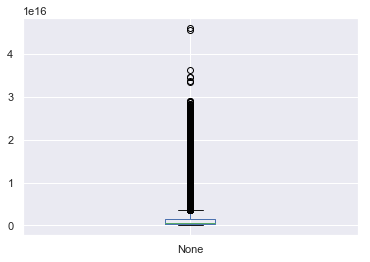

In [42]:
# boxplot
pt_ft_diff.plot(kind='box')

plt.show()

In [43]:
# brief look at the outliers
outliers_case_1 = data.iloc[outliers_pt_ft.index]
outliers_case_1.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
521,664647,1500.0,1500.0,funded,Personal Housing Expenses,Housing,"To buy cement, iron, sand, bricks and hire wor...",SV,El Salvador,Osicala,...,USD,199.0,2014-01-31 21:43:39,2014-03-30 10:10:02,2014-01-28 08:00:00,2014-03-26 13:53:14,21.0,49,female,monthly
799,660131,1450.0,1450.0,funded,Agriculture,Agriculture,to buy agricultural inputs to protect and aid ...,HN,Honduras,Santa Barbara,...,HNL,269.0,2014-01-21 18:37:25,2014-03-26 22:25:57,2014-01-20 08:00:00,2014-03-17 22:04:55,26.0,56,female,monthly
1083,658101,350.0,350.0,funded,Personal Housing Expenses,Housing,"To buy cement, sand, and gravel for installing...",SV,El Salvador,NaN,...,USD,81.0,2014-01-16 15:05:46,2014-03-26 22:22:18,2013-12-20 08:00:00,2014-03-18 18:21:24,14.0,13,male,monthly
1474,658258,650.0,650.0,funded,Grocery Store,Food,to buy products for her grocery store,HN,Honduras,"Choloma, Cortes.",...,HNL,201.0,2014-01-16 20:45:39,2014-03-26 22:25:17,2014-01-08 08:00:00,2014-03-12 16:24:47,14.0,19,female,monthly
1519,419280,575.0,575.0,funded,Sewing,Services,NaN,CO,Colombia,NaN,...,COP,177.0,2012-04-25 12:45:24,2012-07-01 09:00:10,2012-04-23 07:00:00,2012-06-18 00:53:02,14.0,10,NaN,monthly


In [44]:
# comparing with the planned_expiration_time
outliers_case_1['months_to_fund'] = (outliers_case_1['funded_time'] - outliers_case_1['posted_time']).dt.days / 30

# planned_expiration_time columns in days
outliers_case_1['planned_expiration_time_days'] = (outliers_case_1['planned_expiration_time'] - 
                                                   outliers_case_1['posted_time']).dt.days

# cases where months_to_fund > planned_expiration_time_days
outliers_case_1[outliers_case_1['months_to_fund'] > outliers_case_1['planned_expiration_time_days']]

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval,months_to_fund,planned_expiration_time_days


In this case, I will opt to keep the outliers.

***2.2) 'posted_time' and 'disbursed_time'***

In [45]:
(data['posted_time'] - data['disbursed_time']).describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

As we have seen, the chronological order of these two dates does not matter, because the disbursal can be made before the posted time for most of the entities (Field partners). It is necessary to check for outliers, though.

Here I will focus only when the disbursal is made before the posted_time.

In [46]:
# cases where the disbursal is made before the posted_time
pt_dt_pos = data[data['posted_time'] > data['disbursed_time']]

# time difference between the two
pt_dt_pos_diff = pt_dt_pos['posted_time'] - pt_dt_pos['disbursed_time']

# describe
pt_dt_pos_diff.describe()

count                    1273566
mean     16 days 14:42:00.922162
std       9 days 15:11:11.397535
min              0 days 00:00:03
25%       7 days 20:42:53.250000
50%      16 days 02:17:43.500000
75%             26 days 03:07:27
max            118 days 16:28:59
dtype: object

In [47]:
# outliers for the difference between posted_time and disbursed_time (when positive)
outliers_pt_dt = outliers_zscore(pt_dt_pos_diff, 3)

# describe
outliers_pt_dt.describe()

count    135.000000
mean       4.380002
std        1.411533
min        3.023692
25%        3.323745
50%        4.049502
75%        4.600418
max       10.596565
dtype: float64

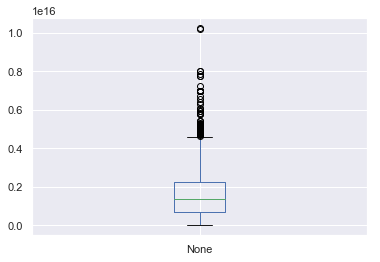

In [48]:
# boxplot
pt_dt_pos_diff.plot(kind='box')

plt.show()

In [49]:
# data regarding these outliers 
data.iloc[outliers_pt_dt.index].head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
17072,114567,7450.0,7450.0,funded,Computers,Services,Training and certification for his computer an...,US,United States,"Atlanta, Georgia",...,USD,131.0,2009-06-10 20:14:22,NaT,2009-03-22 07:00:00,2009-06-21 02:37:18,26.0,236,male,monthly
17358,117254,175.0,175.0,funded,Pigs,Agriculture,To buy pig feed,PH,Philippines,"Surallah, South Cotabato",...,PHP,125.0,2009-06-22 00:58:11,NaT,2009-05-06 07:00:00,2009-06-22 02:05:24,6.0,6,female,bullet
17418,114264,5750.0,5750.0,funded,Services,Services,To buy a car for transporting packages,US,United States,"Queens, New York",...,USD,131.0,2009-06-09 16:55:37,NaT,2009-03-31 07:00:00,2009-06-20 20:18:43,27.0,171,male,monthly
36690,246230,1500.0,1500.0,funded,Butcher Shop,Food,To purchase meat for resale,KG,Kyrgyzstan,Tokmak,...,KGS,135.0,2010-11-09 05:39:58,NaT,2010-09-14 07:00:00,2010-11-15 18:34:32,7.0,46,"female, female, female, female",monthly
37027,245762,700.0,700.0,funded,Restaurant,Food,Purchase of ingredients,PH,Philippines,"Puerto Princesa, Palawan",...,PHP,145.0,2010-11-06 11:49:45,NaT,2010-09-20 07:00:00,2010-11-06 23:45:16,8.0,26,female,irregular


In [50]:
# the difference between the funded_time and posted_time in these outliers
(data.iloc[outliers_pt_dt.index]['funded_time'] - data.iloc[outliers_pt_dt.index]['posted_time']).describe()

count                        131
mean     14 days 13:25:41.870229
std      25 days 18:08:53.087114
min              0 days 01:07:13
25%              2 days 12:55:17
50%              6 days 23:02:20
75%      16 days 21:31:37.500000
max            242 days 17:25:56
dtype: object

There are a few outliers regarding this case. However, when analysing them, we notice that in all of them the difference between the posted_time and funded_time is acceptable, which means that although the disbursal was made long before the posted_time, the loan got funded almost immediatly. This could suggest that these cases were somehow managed by Kiva or the Field Partners.

I will opt for their maintenance in the analysis.

**2.3) 'funded_time' and 'disbursed_time'**

In [51]:
(data['funded_time'] - data['disbursed_time']).describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

Here I focus on the cases where the disbursed_time was filled after the loan was funded. I left apart the cases where the disbursed_time appeared before the funded_time.


In [52]:
# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disbursed_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

I will now divide the analysis between the cases when there was a field partner involved and when there was not.

*Field partner involved*

In [53]:
# cases where the disbursal is made after the funded_time, where there is a field partner involved
dt_ft_pos_partner = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].notnull())]

# time difference between the two
dt_ft_pos_diff_partner = dt_ft_pos_partner['disbursed_time'] - dt_ft_pos_partner['funded_time']

# describe
dt_ft_pos_diff_partner.describe()

count                     104590
mean     17 days 06:47:49.884291
std      12 days 20:47:08.139505
min              0 days 00:01:24
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max             88 days 23:25:52
dtype: object

In [54]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, with a field partner
outliers_dt_ft_partner = outliers_zscore(dt_ft_pos_diff_partner, 3)

# describe
outliers_dt_ft_partner.describe()

count    3214.000000
mean        4.192525
std         0.765157
min         3.002844
25%         3.487668
50%         4.166138
75%         4.916974
max         5.572261
dtype: float64

*Field partner not involved*

In [55]:
# cases where the disbursal is made after the funded_time, where there is not a field partner involved
dt_ft_pos_partner_not = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].isnull())]

# time difference between the two
dt_ft_pos_diff_partner_not = dt_ft_pos_partner_not['disbursed_time'] - dt_ft_pos_partner_not['funded_time']

# describe
dt_ft_pos_diff_partner_not.describe()

count                      13030
mean      8 days 14:59:16.826477
std      10 days 20:39:23.626387
min              0 days 00:00:17
25%       2 days 20:21:33.750000
50%              5 days 12:25:15
75%       9 days 13:06:44.250000
max            182 days 08:31:57
dtype: object

In [56]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, and NO field partner
outliers_dt_ft_partner_not = outliers_zscore(dt_ft_pos_diff_partner_not, 3)

# describe
outliers_dt_ft_partner_not.describe()

count    301.000000
mean       4.579016
std        1.698910
min        3.001596
25%        3.346945
50%        3.989094
75%        5.169267
max       15.996315
dtype: float64

In [57]:
# distribution among countries of the outliers with a field partner involved
data.iloc[outliers_dt_ft_partner.index].country_name.value_counts().head(15)

Philippines    599
Kenya          375
Cambodia       192
Peru           153
El Salvador    150
Nicaragua      109
Uganda         101
Tajikistan      98
Pakistan        85
Colombia        78
Ecuador         75
Nigeria         64
India           61
Paraguay        60
Ghana           59
Name: country_name, dtype: int64

In [58]:
# distribution among countries of the outliers with no field partner involved
data.iloc[outliers_dt_ft_partner_not.index].country_name.value_counts().head(15)

Kenya            76
Philippines      48
Peru             21
Nicaragua        11
Tajikistan       11
United States     8
Pakistan          7
Ghana             7
Cambodia          7
Uganda            7
Ecuador           7
El Salvador       6
Sierra Leone      6
Bolivia           5
Albania           5
Name: country_name, dtype: int64

Looking at the distribution of the outliers among countries, however, we notice that they are somewhat representative, either with or without a partner involved, so I will opt to keep the values for further analysis.

##### - When there is a missing disbursed_time value and the loan has been funded: (Kenya & USA)

In [59]:
# Cases where there is a missing disbursed_time and the loan has been funded
missing_disb = data[(data['disbursed_time'].isna()) & (data['funded_time'].notnull())]
missing_disb.count().funded_time

271

In [60]:
# head
missing_disb.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
37765,1407950,8000.0,8000.0,funded,Clothing,Clothing,support a local business dedicated to providin...,US,United States,NaN,...,USD,NaN,2017-11-02 01:11:32,2017-12-17 22:44:40,NaT,2017-12-16 21:14:45,36.0,56,male,bullet
70179,1164746,3000.0,3000.0,refunded,Services,Services,NaN,US,United States,NaN,...,USD,NaN,2016-10-05 01:28:13,2016-11-10 18:43:40,NaT,2016-11-10 00:40:29,24.0,57,NaN,bullet
70314,1088448,5000.0,5000.0,refunded,Agriculture,Agriculture,NaN,US,United States,NaN,...,USD,NaN,2015-04-15 12:35:57,2015-06-05 00:30:01,NaT,2016-02-11 17:44:48,30.0,106,NaN,bullet
89049,1428619,2000.0,2000.0,funded,Entertainment,Entertainment,fund the renovation of my retail store so my b...,US,United States,NaN,...,USD,NaN,2017-12-05 18:50:15,2018-01-20 12:38:16,NaT,2017-12-23 14:32:29,18.0,25,male,bullet
91347,1084914,125.0,125.0,refunded,Clothing,Clothing,NaN,KE,Kenya,NaN,...,KES,NaN,2014-10-28 06:32:19,2014-12-27 17:45:36,NaT,2014-12-26 19:09:42,3.0,12,NaN,bullet


In [61]:
# geographical location of the missing values
missing_disb.country_name.value_counts()

Kenya            216
United States     55
Name: country_name, dtype: int64

In [62]:
# sector name of those missing values 
missing_disb.sector_name.value_counts()

# Note: 97% of the Agriculture cases are from Kenya

Agriculture       79
Services          46
Food              46
Retail            44
Clothing          26
Arts               9
Transportation     7
Construction       5
Entertainment      4
Health             4
Education          1
Name: sector_name, dtype: int64

Since the missing values appear in only two countries in the world, I will generalize and check for outliers by comparing them with the typical delay to disburse in each country.

##### USA

In [63]:
# cases in the United States where the disbursal is made after the loan is funded
usa_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'United States']

# delay values 
delay_usa = (usa_dt_ft_pos['disbursed_time'] - usa_dt_ft_pos['funded_time'])

# description of the delay to disburse in the United States
print(delay_usa.describe())

# I will consider the mean value for the typical delay to disburse in the United States
delay_usa.mean()

count                      3527
mean     5 days 06:43:32.021831
std      5 days 22:55:18.397383
min             0 days 00:00:17
25%             2 days 00:26:18
50%             3 days 23:05:12
75%      6 days 05:07:38.500000
max           106 days 12:48:50
dtype: object


Timedelta('5 days 06:43:32.021831')

In [64]:
# missing values filtered by country: United States
usa = missing_disb[missing_disb['country_name'] == 'United States']

# description of the delay of disbursal, in the United States, after the loan is funded 
(max(data['disbursed_time']) - usa['funded_time']).describe()

count                          55
mean     248 days 10:26:48.945454
std      398 days 00:49:45.201273
min              78 days 20:59:20
25%       80 days 17:18:49.500000
50%              82 days 14:37:29
75%              99 days 17:58:27
max            1927 days 06:24:45
Name: funded_time, dtype: object

##### Kenya

In [65]:
# cases in Kenya where the disbursal is made after the loan is funded
kenya_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'Kenya']

# delay values 
delay_kenya = (kenya_dt_ft_pos['disbursed_time'] - kenya_dt_ft_pos['funded_time'])

# description of the delay to disburse in Kenya
print(delay_kenya.describe())

# I will consider the mean value for the typical delay to disburse in Kenya
delay_kenya.mean()

count                      20659
mean     17 days 11:42:49.691708
std      17 days 07:31:00.633473
min              0 days 00:02:00
25%              5 days 06:34:47
50%             13 days 12:58:22
75%      24 days 14:37:12.500000
max            182 days 08:31:57
dtype: object


Timedelta('17 days 11:42:49.691708')

In [66]:
# missing values filtered by country: Kenya
kenya = missing_disb[missing_disb['country_name'] == 'Kenya']

# description of the delay of disbursal, in Kenya, after the loan is funded
(max(data['disbursed_time']) - kenya['funded_time']).describe()

count                          216
mean     1011 days 06:15:02.481481
std       147 days 12:35:07.238205
min              914 days 11:19:07
25%              921 days 01:30:39
50%       942 days 19:49:48.500000
75%             1023 days 09:07:22
max             1600 days 10:20:21
Name: funded_time, dtype: object

In Kenya, they are all off the scale, even more than in the USA. 

I will remove them from analysis, both USA and Kenya values.

In [67]:
# removing the rows
data = data.drop(missing_disb.index)

# new shape
data.shape

(1419122, 21)

## 2) Exploratory Data Analysis

Now that the data is clean, we want to start by studying the characteristics of the main variables and how they interacted with each other over time.

##### Evolution of the number of loans in each phase: 2006-2017

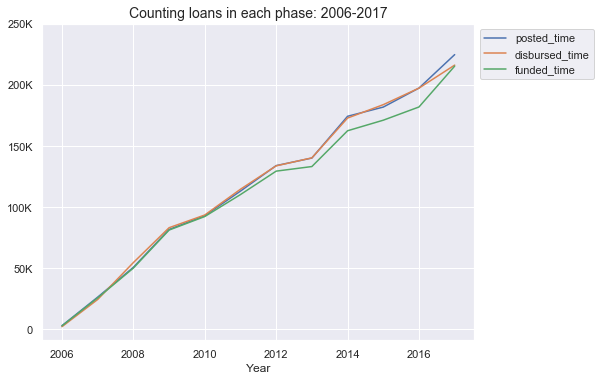

In [68]:
# 2006 - 2017

# main variables
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-1].plot(grid=True)

# formatting
plt.yticks([0, 50000, 100000, 150000, 200000, 250000], ['0', '50K', '100K', '150K', '200K', '250K'])
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2017", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))
plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In a first look, we notice three major time periods:

**Until 2010**, the number of posted loans were closely matched in time by the amount of funding and disbursals. After that, **between 2010 and 2014**, we started to see a clear separation between each of the main variables: it suggests that the loans, continuing with almost always a close match between the posting phase and disbursal, started to lose its efficiency regarding the funding of the projects.  

**After 2014** till the end, the differences continued to aggravate between the postings and funding, and the number of disbursals and postings became just a bit volatile over time. Curiously, the number of funding gained proximity with the number of disbursals, especially in the last year.

Still, this could be related to missing values or other factors, so it deserves further exploration.

**2006-2010**

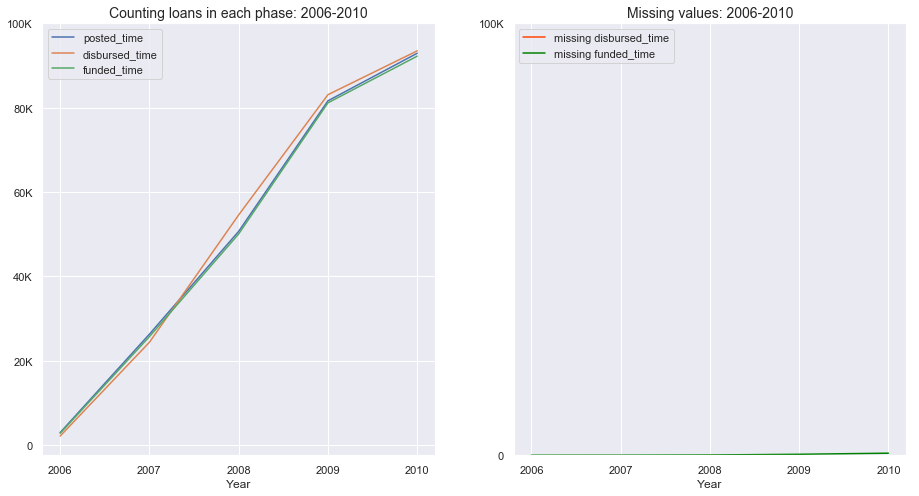

In [69]:
# 2006 - 2010

# main variables
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[:-8].plot(grid=True)

# formatting
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K', '60K', '80K', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2006-2010", fontsize=14)
plt.legend(loc='upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:1].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].dt.year.isna()]['posted_time'].dt.year.value_counts().sort_index()[:5].plot(grid=True, label="missing funded_time", color='green')

# formatting
plt.yticks([0, 100000], ['0', '100K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Missing values: 2006-2010", fontsize=14)
plt.legend(loc='upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

As said before, the process was smooth until 2010.

**2010-2014**

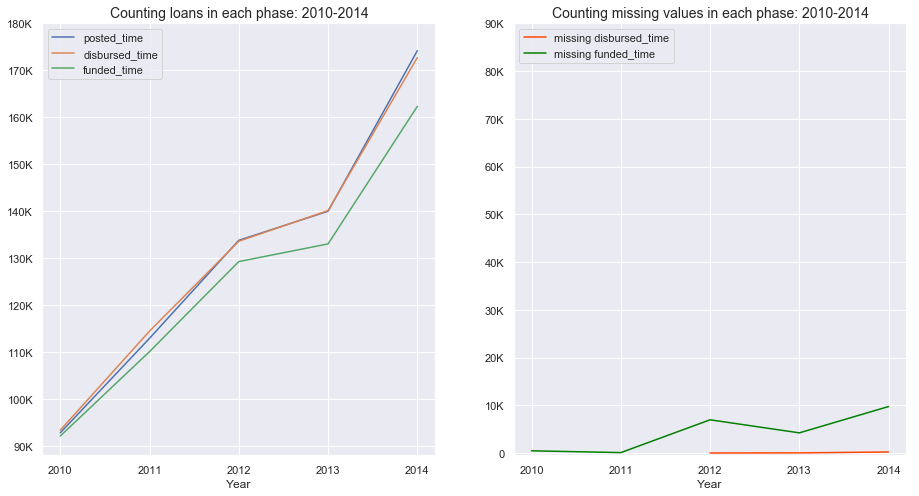

In [70]:
# 2010 - 2014

# main variables
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True)

# formatting
plt.yticks([90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000], ['90K', '100K', '110K', '120K', '130K', '140K', '150K', '160K', '170K', '180K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[1:4].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[4:9].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 2000, 4000, 6000, 8000, 10000], ['0', '2K', '4K', '6K', '8K', '10K'])
# plt.yticks([0, 10000, 20000, 180000], ['0', '10K', '20K', '180K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K', '90K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2010-2014", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

Between 2010 and 2014, the funding started to lose track of the posted loans mainly between 2010 and 2011. This difference, however, could be due to the cyclical nature of the process, as it will be shown below. Thereafter, the difference was mostly due to the funded missing values.

**2014-2017**

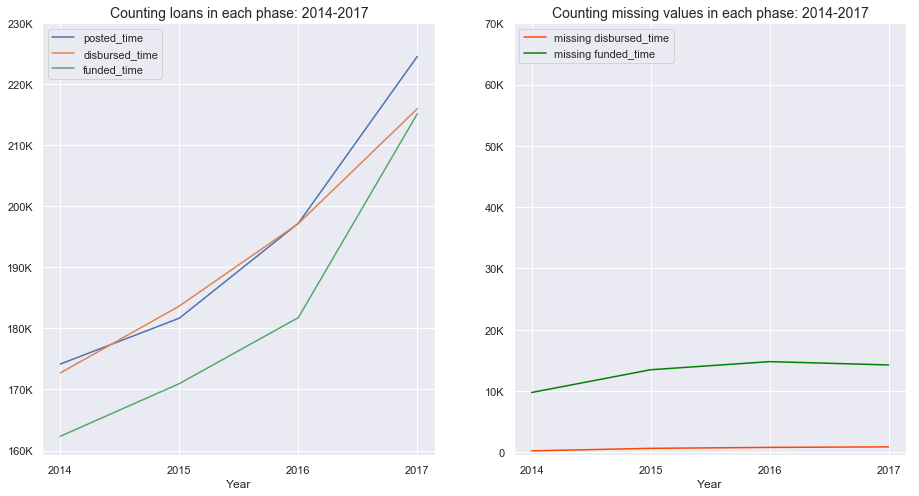

In [71]:
# 2014 - 2017

# main variables 
plt.subplot(1, 2, 1)
data[data['posted_time'].notnull()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
data[data['disbursed_time'].notnull()]['disbursed_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)
data[data['funded_time'].notnull()]['funded_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True)

# formatting
plt.yticks([160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000], ['160K', '170K', '180K', '190K', '200K', '210K', '220K', '230K'])
plt.locator_params(axis='x', nbins=5)
# plt.locator_params(axis='y', nbins=5) 
plt.xlabel("Year")
plt.title("Counting loans in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')


# missing values
plt.subplot(1, 2, 2)
data[data['disbursed_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[3:].plot(grid=True, label="missing disbursed_time", color='orangered')
data[data['funded_time'].isna()]['posted_time'].dt.year.value_counts().sort_index()[8:-1].plot(grid=True, label="missing funded_time", color='green')

# formatting
# plt.yticks([0, 4000, 8000, 12000, 16000], ['0', '4K', '8K', '12K', '16K'])
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])
plt.locator_params(axis='x', nbins=5)
plt.xlabel("Year")
plt.title("Counting missing values in each phase: 2014-2017", fontsize=14)
plt.legend(loc= 'upper left')

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

In the last phase, although the difference between the number of missing values of the disbursals and fundings remained relatively constant, the number of fundings augmented more than disbursals, equalizing them on the final stretch.

We can see that the deviation increase was mostly due to missing values until 2014. If we take that apart, the lines are somewhat at the same pace. This was not the case during the final 4 years, given the disbursals data we have. However, since it captures data at the end of the scale, and given the cyclical nature of the Kiva process, as shown below, it could still be related to the fact that the disbursal data was not yet inserted, lagging a few days or weeks.

* In **conclusion**, we see that from 2006 till 2010 the process was smooth and without significant delays. The number of loans not funded started then to increase year after year until 2017, ending with approximately 15K loans to fund. This does not means delays got significantly worse year after year, but they're there.

#### The cyclical nature of the Kiva process

When looking at the disaggregation by month, we can see the <font color=green>**cyclical nature**</font>  of the journey of Kiva loans.

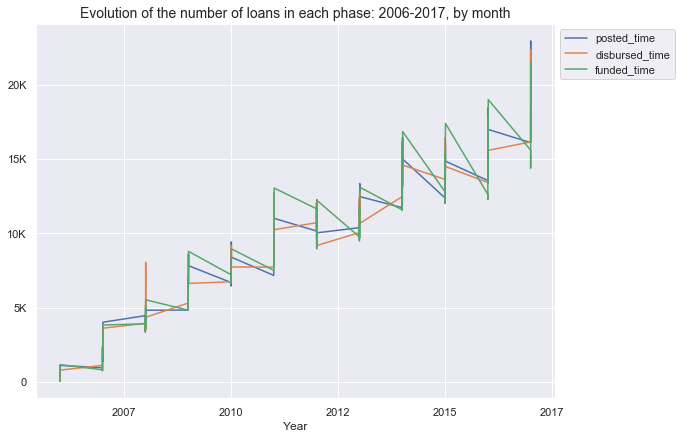

In [72]:
# evolution of the main variables, by month
evol_posted = data[data['posted_time'].notnull()]['posted_time']
evol_disbursed = data[data['disbursed_time'].notnull()]['disbursed_time']
evol_funded = data[data['funded_time'].notnull()]['funded_time']

# plot months (except 2018)
evol_posted.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)
evol_disbursed.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-4].plot(grid=True)
evol_funded.map(lambda x: 1000*x.year + x.month).value_counts().sort_index()[:-2].plot(grid=True)

plt.locator_params(axis='x', nbins=5)
plt.xticks([2007500, 2010000, 2012500, 2015000, 2017500], ["2007", "2010", "2012", "2015", "2017"])
plt.yticks([0, 5000, 10000, 15000, 20000], ["0", "5K", "10K", "15K", "20K"])
plt.xlabel("Year")
plt.title("Evolution of the number of loans in each phase: 2006-2017, by month", fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))

plt.subplots_adjust(left=0, bottom=-0.3, right=1.2, top=1, wspace=0.6, hspace=0.4)
plt.show()

These cycles suggest that Kiva gather many loan requests before they post on their website. The fundings and disbursals follow the announcements (or, since the disbursal is almost always the first to occur, the posting and funding follow the disbursals).

To further examine this cyclical nature, let us now display the aggregated values by month and finally, by day.

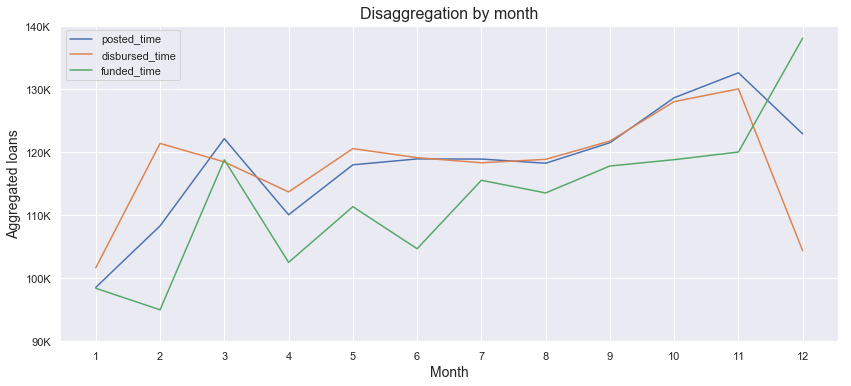

In [73]:
# Display aggregated values, by month

# posted_time
posted_time_months = data['posted_time'].dt.month
posted_time_by_months = data['posted_time'].groupby(posted_time_months).count()
posted_time_by_months.plot()

# disbursed_time
disbursed_time_months = data['disbursed_time'].dt.month
disbursed_time_by_months = data['disbursed_time'].groupby(disbursed_time_months).count()
disbursed_time_by_months.plot()

# funded_time
funded_time_months = data['funded_time'].dt.month
funded_time_by_months = data['funded_time'].groupby(funded_time_months).count()
funded_time_by_months.plot()

plt.subplots_adjust(left=0, bottom=-0.1, right=1.8, top=1, wspace=0.6, hspace=0.4)
plt.title("Disaggregation by month", fontsize=16)
plt.xticks(range(1, 13))
plt.yticks([90000, 100000, 110000, 120000, 130000, 140000], ["90K", "100K", "110K", "120K", "130K", "140K"])
plt.ylabel("Aggregated loans", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.legend(['posted_time', 'disbursed_time', 'funded_time'])
plt.show()

As we can see, there is a **slight tendency to post, disburse and fund as the year comes to an end**.

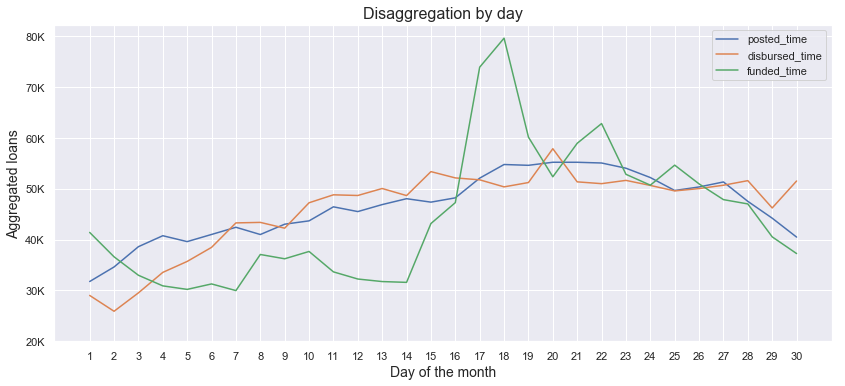

In [74]:
# Display aggregated values, by day

# posted_time
posted_time_days = data['posted_time'].dt.day
posted_time_by_days = data['posted_time'].groupby(posted_time_days).count()
posted_time_by_days.iloc[:-1].plot()

# disbursed_time
disbursed_time_days = data['disbursed_time'].dt.day
disbursed_time_by_days = data['disbursed_time'].groupby(disbursed_time_days).count()
disbursed_time_by_days.iloc[:-1].plot()

# funded_time
funded_time_days = data['funded_time'].dt.day
funded_time_by_days = data['funded_time'].groupby(funded_time_days).count()
funded_time_by_days.iloc[:-1].plot()

plt.subplots_adjust(left=0, bottom=-0.1, right=1.8, top=1, wspace=0.6, hspace=0.4)
plt.title("Disaggregation by day", fontsize=16)
plt.xticks(range(1, 31))
plt.yticks([20000, 30000, 40000, 50000, 60000, 70000, 80000], ["20K", "30K", "40K", "50K", "60K", "70K", "80K"])
plt.ylabel("Aggregated loans", fontsize=14)
plt.xlabel("Day of the month", fontsize=14)
plt.legend(['posted_time', 'disbursed_time', 'funded_time'])
plt.show()

While the posting and disbursing periods relatively aggregate the same amount of loans throughout the month, there is a strong pressure to fund the loans during the **3rd week** of the month.

##### Now, looking at the time differences between the main variables

- **'posted_time' vs 'disbursed_time'**

In [75]:
# posted_time - disbursed_time
post_disb = data['posted_time'] - data['disbursed_time']

In [76]:
post_disb.describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

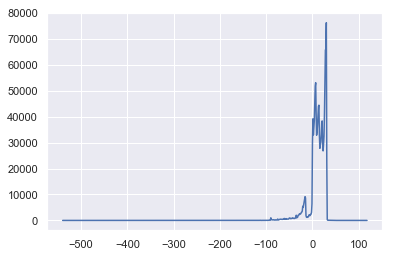

In [77]:
# Glimpse of the distribution
post_disb.dt.days.value_counts().sort_index().plot()

In [78]:
# difference between disbursal and posting between -35 and +32 days, in percentage
print("Between -35 and +32 days:", int(round(post_disb.dt.days.value_counts().sort_index()[-35:32].sum() / 
                                             post_disb.dt.days.value_counts().sum()*100)), "%")

# difference between disbursal and posting between 0 and +32 days, in percentage
print("Between 0 and +32 days:", int(round(post_disb.dt.days.value_counts().sort_index()[0:32].sum() / 
                                           post_disb.dt.days.value_counts().sum()*100)), "%")

Between -35 and +32 days: 98 %
Between 0 and +32 days: 90 %


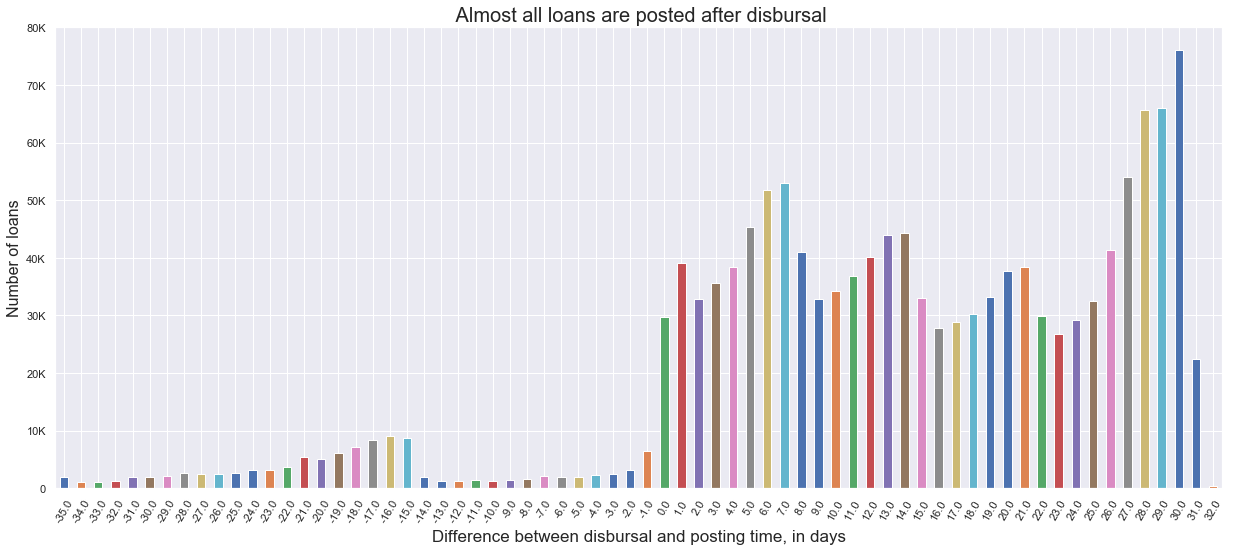

In [79]:
# distribution of 98% of the selected data
post_disb.dt.days.value_counts().sort_index()[-35:32].plot(kind='bar')

# formatting
plt.title(" Almost all loans are posted after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between disbursal and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], 
           ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

- **98% of the differences between the time of disbursal and posting of loans occur on a range of -35 days and +32 days**.


- Moreover, **90% of the differences are positive**, that is, pre-disbursals.

As we can confirm, most (at least 90%) of the disbursals are made by field partners, the only ones who can pre-disburse.

- **'posted_time' vs 'funded_time'**

In [80]:
# funded_time - posted_time
fund_post = data['funded_time'] - data['posted_time']

In [81]:
fund_post.describe()

count                    1354847
mean     12 days 14:55:24.936868
std      13 days 11:14:07.002439
min              0 days 00:02:00
25%       3 days 13:14:12.500000
50%              7 days 18:27:30
75%      18 days 11:31:19.500000
max            533 days 17:22:00
dtype: object

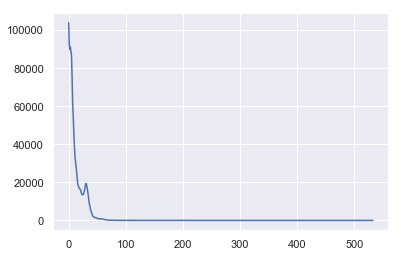

In [82]:
# Glimpse of the distribution
fund_post.dt.days.value_counts().sort_index().plot()

In [83]:
# difference between funding and posting between 0 and +50 days, in percentage
print("Between 0 and +50 days:", int(round(fund_post.dt.days.value_counts().sort_index()[0:50].sum() /
                                           fund_post.dt.days.value_counts().sum()*100)), "%")

# difference between funding and posting between 0 and +30 days, in percentage
print("Between 0 and +30 days:", int(round(fund_post.dt.days.value_counts().sort_index()[0:30].sum() /
                                           fund_post.dt.days.value_counts().sum()*100)), "%")

Between 0 and +50 days: 99 %
Between 0 and +30 days: 89 %


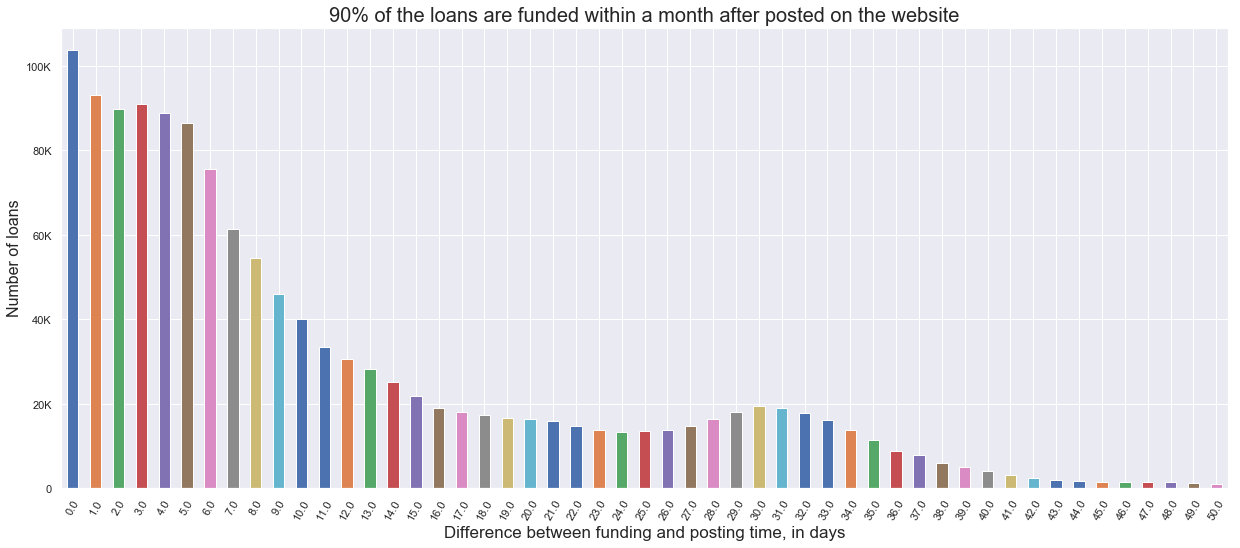

In [84]:
# distribution of 99% of the selected data
fund_post.dt.days.value_counts().sort_index()[0:50].plot(kind='bar')

# formatting
plt.title("90% of the loans are funded within a month after posted on the website", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and posting time, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

When we look at the time a loan takes to get funded **since the time it is posted on Kiva website**, we see that **99% of them are funded within 50 days, and almost 90% within 30 days**.

This barplot suggests that the time between posting and funding could be described as an Exponential distribution. I will create an Empirical CDF of these time differences and compare it with a theoretical CDF.

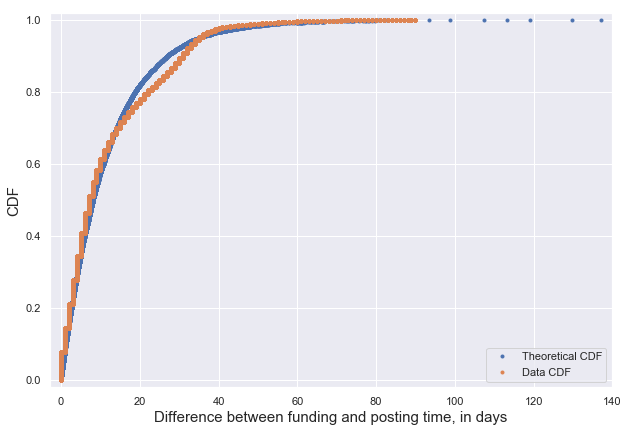

In [85]:
# ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y

# time differences between funding and posting times array
fund_post_array = fund_post.dt.days

# within 90 days (99%)
fund_post_array_90 = fund_post_array[fund_post_array.between(0, 90)]


# ECDF from the data: x, y
x, y = ecdf(fund_post_array_90)

# Drawing an exponential distribution with parameter tau
tau = np.mean(fund_post_array_90)
theor = np.random.exponential(tau, 10000)

# constructing the CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(theor)

# Overlaying the plots
plt.plot(x_theor, y_theor, marker='.', linestyle='none')
plt.plot(x, y, marker='.', linestyle='none')

# Margins and axis labels
plt.margins(0.02)
plt.xlabel("Difference between funding and posting time, in days", fontsize=15)
plt.ylabel('CDF', fontsize=15)
plt.legend(('Theoretical CDF', 'Data CDF'), loc='lower right')

# Show the plot
plt.subplots_adjust(left=0, bottom=-0.3, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

It seems to fit an exponential distribution.

- **'disbursed_time' vs 'funded_time'**

Now, since we know that most of the loans are pre-disbursed, we should now take a look at the combination of the two previous analysis, that is, at the difference between the time of disbursal and funding. 

In [86]:
# funded_time - disbursed_time
fund_disb = data['funded_time'] - data['disbursed_time']

In [87]:
fund_disb.describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

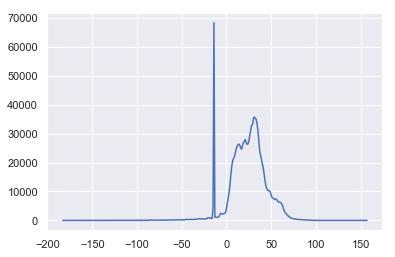

In [88]:
# Glimpse of the distribution
fund_disb.dt.days.value_counts().sort_index().plot()

In [89]:
# difference between funding and disbursal between -18 and +70 days
print("between -18 and +70 days:", int(round(fund_disb.dt.days.value_counts().sort_index()[-18:70].sum()/
                                             fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs only after the funding is complete
print("disbursal after funding:", int(round(fund_disb.dt.days.value_counts().sort_index()[-3000:0].sum()/
                                            fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs until 14 days after the loan is funded
print("disbursal after funding (until 14 days):", int(round(fund_disb.dt.days.value_counts().sort_index()[-14:0].sum()/
                                                            fund_disb.dt.days.value_counts().sum()*100)), "%")

# when the disbursal occurs 14 days after the loan is funded
print("disbursal after funding (14th day):", int(round(fund_disb.dt.days.value_counts().sort_index()[-14].sum()/
                                                       fund_disb.dt.days.value_counts().sum()*100)), "%")

between -18 and +70 days: 98 %
disbursal after funding: 9 %
disbursal after funding (until 14 days): 7 %
disbursal after funding (14th day): 5 %


In [90]:
# difference between funding and disbursal between 0 and +30 days
print(int(round(fund_disb.dt.days.value_counts().sort_index()[0:30].sum()/
                fund_disb.dt.days.value_counts().sum()*100)))

# difference between funding and disbursal between 0 and +60 days
print(int(round(fund_disb.dt.days.value_counts().sort_index()[0:60].sum()/
                fund_disb.dt.days.value_counts().sum()*100)))

53
88


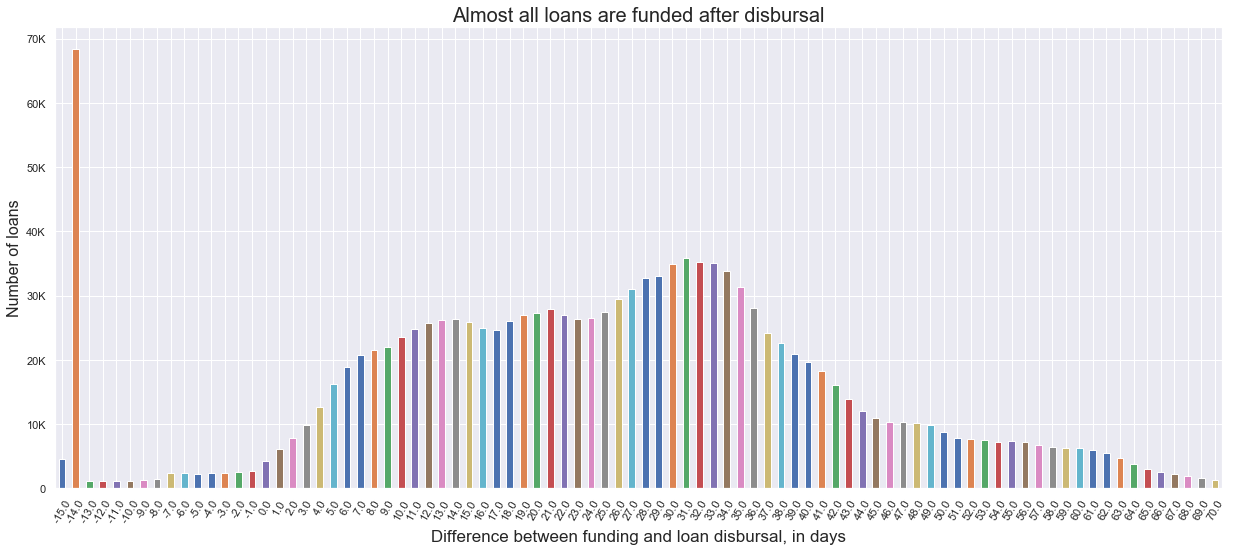

In [91]:
# distribution of 98% of the total data
fund_disb.dt.days.value_counts().sort_index()[-15:70].plot(kind='bar')

# formatting
plt.title("Almost all loans are funded after disbursal", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Difference between funding and loan disbursal, in days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], ['0', '10K', '20K', '30K', '40K', '50K', '60K', '70K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

As we can see, close to **10% of the total loans are disbursed after the funding is complete**, and 5% occur 14 days after the time of funding.

In most cases, a pre-disbursal occurs and only then the funding period commences.

Confirming if the 5% cases where disbursal occurs 14 days after funding are distributed over time or concentrated in a few occasions:

In [92]:
# when disbursal occurs 14 days after funding time
forteen_days = data[(data['funded_time'] - data['disbursed_time']).dt.days == -14]['funded_time']

# in how many months this occurs
forteen_days.map(lambda x: 1000*x.year + x.month).value_counts().sort_index().count()

127

It is regular over time, suggesting, again, the cyclical nature of the loan process.

**Real time to fund**

- Since this analysis includes cases where the disbursal occurs after the posting time, now we will look at **the real time a loan takes to get funded**. To do that, we need the difference between the funding time and the disbursal or posting time, depending on which of these occurred first.

In [93]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# loan time 1 & 2
loan_time_1 = start_1['funded_time'] - start_1['posted_time']
loan_time_2 = start_2['funded_time'] - start_2['disbursed_time']

#concatenate
loan_time = pd.concat([loan_time_1.dt.days, loan_time_2.dt.days], axis=0)

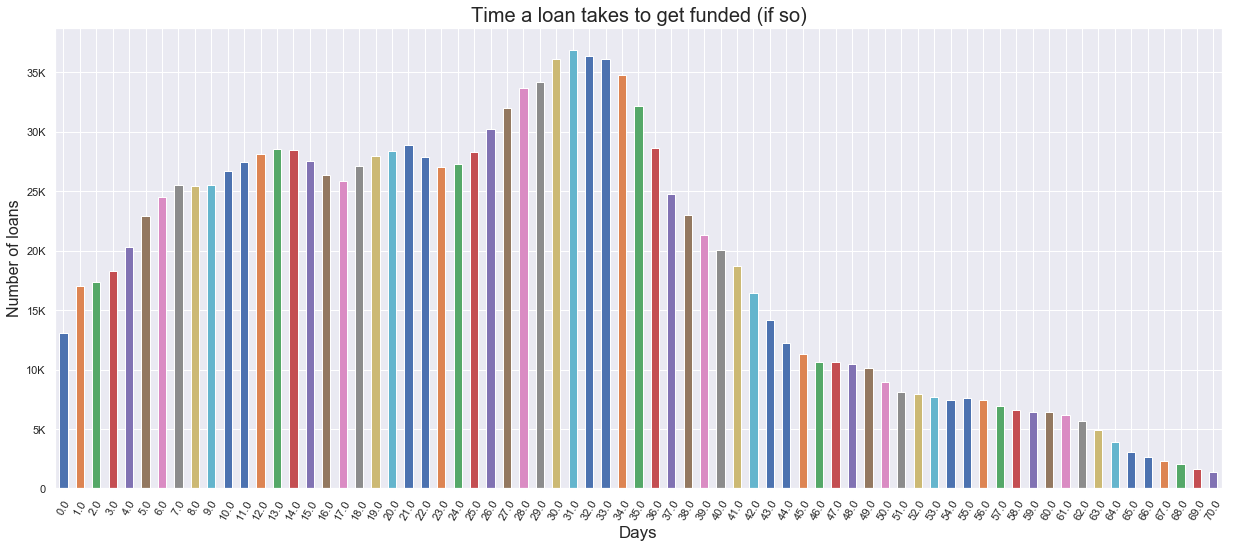

In [94]:
# 99% of the data
loan_time_99 = loan_time.value_counts().sort_index()[0:70]

# distribution
loan_time_99.plot(kind='bar')

# formatting
plt.title("Time a loan takes to get funded (if so)", fontsize=20)
plt.xticks(rotation=60)
plt.xlabel("Days", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000], ['0', '5K', '10K','15K', '20K', '25K', '30K', '35K'])

plt.subplots_adjust(left=0, bottom=-0.6, right=2.7, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [95]:
# percentage of loans that get funded within a month
print("1 month:", int(round(loan_time.value_counts().sort_index()[0:30].sum()/loan_time.value_counts().sum()*100)), "%")

# percentage of loans that get funded within 2 months and 10 days
print("70 days:", int(round(loan_time.value_counts().sort_index()[0:70].sum()/loan_time.value_counts().sum()*100)), "%")

1 month: 60 %
70 days: 99 %


In [96]:
# loans not funded yet
print(round(data[(data['posted_time'].notnull()) & (data['funded_time'].isnull())].count().loan_id/data.posted_time.count()*100), "%")

5.0 %


5% of all loans are not funded yet. Of those that are:

- <font color=green>**Close to 60% are funded within a month.**</font> This happens almost in a linear way as the month advances.
- <font color=green>**99% are funded within 2 months and 10 days.**</font>

As a reminder, 9% of the total loans are only disbursed after they are funded (with 7% within two weeks).

##### Is it a normal distribution?

In [97]:
# represented data
rep_loan = loan_time[loan_time.between(0, 70)]

# D'Agostino's K-squared test
stat, p_value = normaltest(rep_loan)
print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=46105.594; p-value=0.000


Assuming a significance level of 1%, we have sufficient statistical evidence to reject the hypothesis that assumes that the time a loan takes to get funded follows a normal distribution.

ECDF:

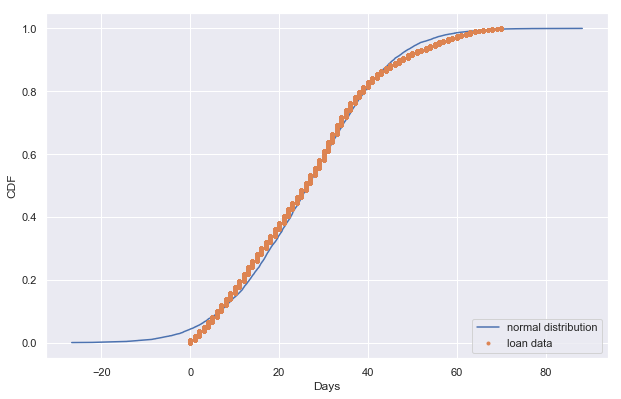

In [98]:
# ECDF

# mean and standard deviation of the data
mean_loan_time = np.mean(rep_loan)
std_loan_time = np.std(rep_loan)

# 10,000 samples out of a normal distribution with mean_temp and std_temp
samples = np.random.normal(mean_loan_time, std_loan_time, size=10000)

# CDF of the samples and of the temperature data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(rep_loan)

# Plot
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.legend(('normal distribution', 'loan data'), loc='lower right')
plt.xlabel('Days')
plt.ylabel('CDF')

plt.subplots_adjust(left=0, bottom=-0.2, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

When comparing the CDFs, however, they seem close. The hypothesis test made above considered negative values.

<font color=green>**General characteristics:**</font>

In [99]:
# all data
print(loan_time.describe().apply(lambda x: format(x, 'f')))

count    1354847.000000
mean          26.995140
std           16.891946
min            0.000000
25%           14.000000
50%           26.000000
75%           36.000000
max          533.000000
dtype: object


*Assuming the normality of the data*, we can build a 95% confidence interval for the average time to fund a loan:

In [100]:
# margin of error 
margin_error = stats.norm.ppf(0.975) * np.std(loan_time)  

# 95% confidence interval
c_interval_left = np.mean(loan_time) - margin_error
c_interval_right = np.mean(loan_time) + margin_error

print("confidence interval: [", c_interval_left, ",", c_interval_right, "]")

confidence interval: [ -6.112453985619258 , 60.10273480699614 ]


We can be 95% confident that a loan is funded within 2 months, on average, but this statistic does not help a lot. Let us see for the standard deviation:

In [101]:
# Generate bootstrap replicate
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data))) 

# Generate bootstrap replicates
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for i in range(size)])

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


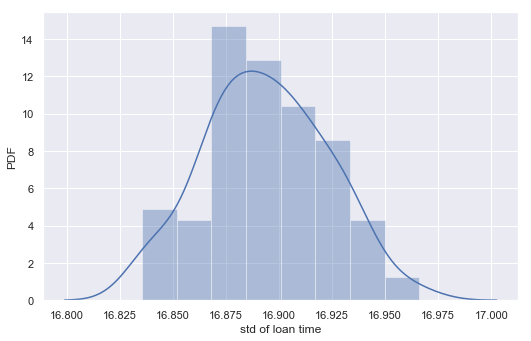

In [102]:
# Generate 100 bootstrap replicates of the *std*: bs_replicates
bs_replicates = draw_bs_reps(loan_time.dropna(), np.std, 100)

# histogram of the results
sns.distplot(bs_replicates)
plt.xlabel('std of loan time')
plt.ylabel('PDF')

# plot
plt.subplots_adjust(left=0, bottom=0, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

As we can see, it is not normally distributed.

In [103]:
print("\n95% confidence interval for the std of loan_time:", np.percentile(bs_replicates, [2.5, 97.5]))


95% confidence interval for the std of loan_time: [16.83907792 16.94539274]


#####  **What may cause delays, then?**

##### Do countries have influence regarding delays?

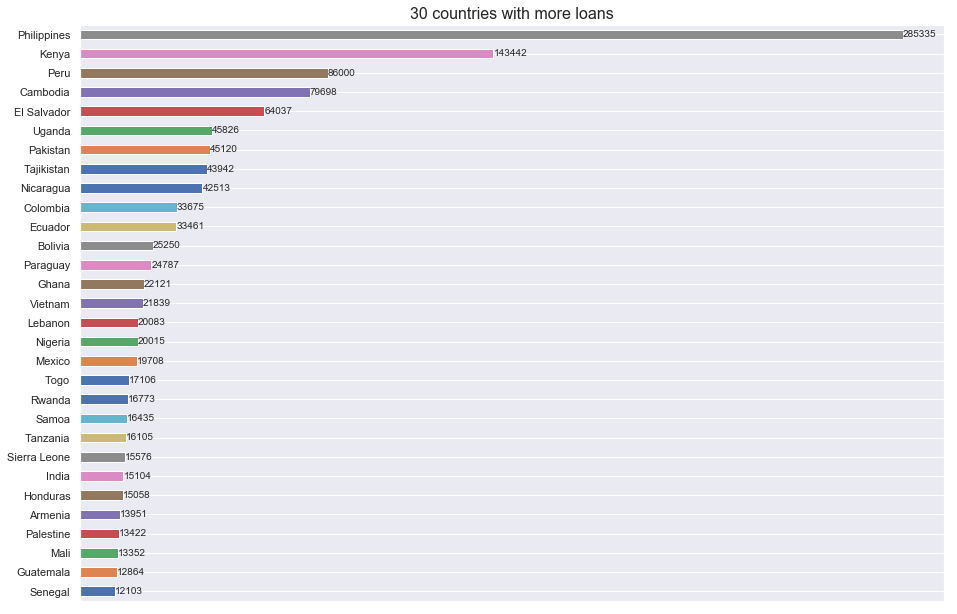

In [104]:
# Distribution of loans across countries

country_loans = data['country_name'].value_counts(ascending=True)[-30:]
country_loans_idx = data['country_name'].value_counts().index
pos = np.arange(len(country_loans))

# add the values to the side of each bar
for p, cidx, cl in zip(pos, country_loans_idx, country_loans):
    plt.annotate(cl, xy=(cl, p), va='center')

# formatting
plt.xticks([])
plt.title("30 countries with more loans", fontsize=16)
plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0, hspace=0.6)

country_loans.plot(kind='barh')
plt.show()

In [105]:
# 6 countries with more loan requests
print(data['country_name'].value_counts()[0:6])

# percentagewise
print(round(data['country_name'].value_counts()[0:6].sum()/data['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143442
Peru            86000
Cambodia        79698
El Salvador     64037
Uganda          45826
Name: country_name, dtype: int64
50.0


**50% of the loans go to 6 countries:** *Philippines, Kenya, Peru, Cambodia, El Salvador and Uganda*.

In [106]:
# 20 countries with more loan requests
print(data['country_name'].value_counts()[0:20])

# percentagewise
print(round(data['country_name'].value_counts()[0:20].sum()/data['country_name'].value_counts().sum()*100))

Philippines    285335
Kenya          143442
Peru            86000
Cambodia        79698
El Salvador     64037
Uganda          45826
Pakistan        45120
Tajikistan      43942
Nicaragua       42513
Colombia        33675
Ecuador         33461
Bolivia         25250
Paraguay        24787
Ghana           22121
Vietnam         21839
Lebanon         20083
Nigeria         20015
Mexico          19708
Togo            17106
Rwanda          16773
Name: country_name, dtype: int64
77.0


**77% of the loans go to 20 countries.**

**How is the distribution of the time to fund for each of the main 6 countries?**

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


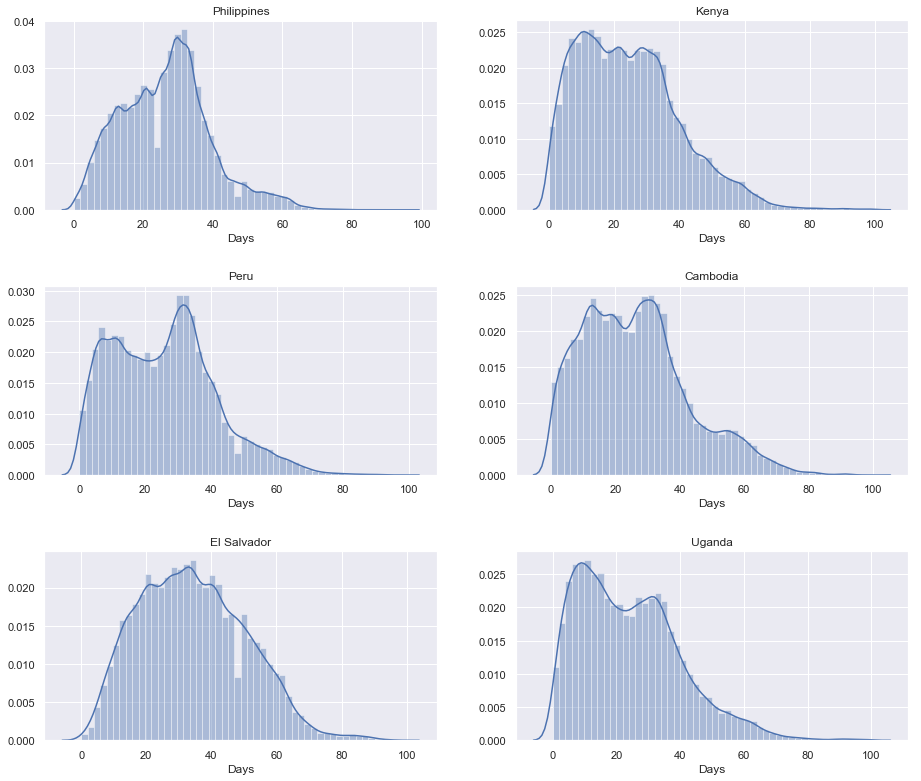

In [107]:
# Prepare dataset

# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_2 = pd.concat([start_1, start_2], axis=0)
data_2 = data_2.set_index('country_name')

# total differences
start_1_countries = data_2[data_2['posted_time'] < data_2['disbursed_time']]
start_2_countries = data_2[data_2['posted_time'] > data_2['disbursed_time']]

# loan_time_countries 1 & 2
loan_time_1_countries = start_1_countries['funded_time'] - start_1_countries['posted_time']
loan_time_2_countries = start_2_countries['funded_time'] - start_2_countries['disbursed_time']

#concatenate
loan_time_countries = pd.concat([loan_time_1_countries.dt.days, loan_time_2_countries.dt.days], axis=0)

##############################

# countries time to fund
countries_6_list = ['Philippines', 'Kenya', 'Peru', 'Cambodia', 'El Salvador', 'Uganda']
countries_6 = {}

for i in countries_6_list:
    countries_6[i] = loan_time_countries.loc[i]
    countries_6[i] = countries_6[i][countries_6[i].between(0, 100)]
    
# plots
for i, country in enumerate(countries_6_list):
    plt.subplot(3, 2, i + 1)
    sns.distplot(countries_6[country])
    plt.title(country)
    plt.xlabel("Days")

plt.subplots_adjust(left=0, bottom=-1.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

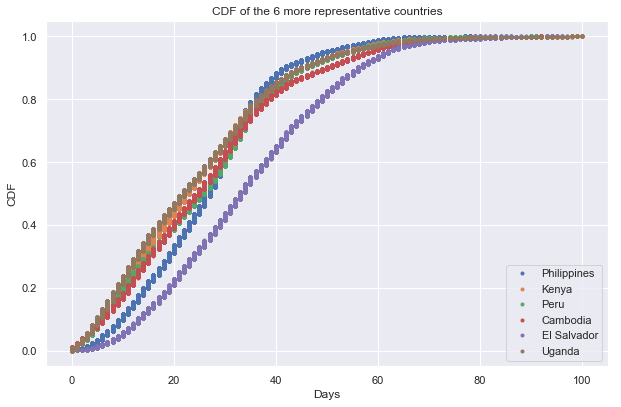

In [108]:
# ECDF's

for country in countries_6_list:
    x, y = ecdf(countries_6[country])
    plt.plot(x, y, marker='.', linestyle='none')

plt.legend(countries_6_list, loc='lower right')
plt.xlabel('Days')
plt.ylabel('CDF')
plt.title("CDF of the 6 more representative countries")
plt.subplots_adjust(left=0, bottom=-0.2, right=1.3, top=1, wspace=0, hspace=0)
plt.show()

We clearly distinguish El Salvador from the other ones. It might be useful in further analysis. El Salvador takes 5% of the loans. The Philippines (20%) could also be a motive for further analysis.

#####  When a loan is funded (96% of the data), how long does it take to get that funding, on average, in each country? Does the number of loans they have have any impact?

In [109]:
# redefine country_loans: include all
country_loans = data['country_name'].value_counts(ascending=True)

#concatenate
loan_time_amounts = pd.concat([start_1_countries.loan_amount, start_2_countries.loan_amount], axis=0)

# create list of countries and respective mean time of loan funding
countries_nr_loans = []
avg_time_fund = []
size_loans = []

for i in range(country_loans.count()):
    if country_loans.index[i] in loan_time_countries.index:
        countries_nr_loans.append(country_loans[i])
        avg_time_fund.append(round(loan_time_countries.loc[country_loans.index[i]].mean()))
        size_loans.append(round(loan_time_amounts.loc[country_loans.index[i]].mean())/10)

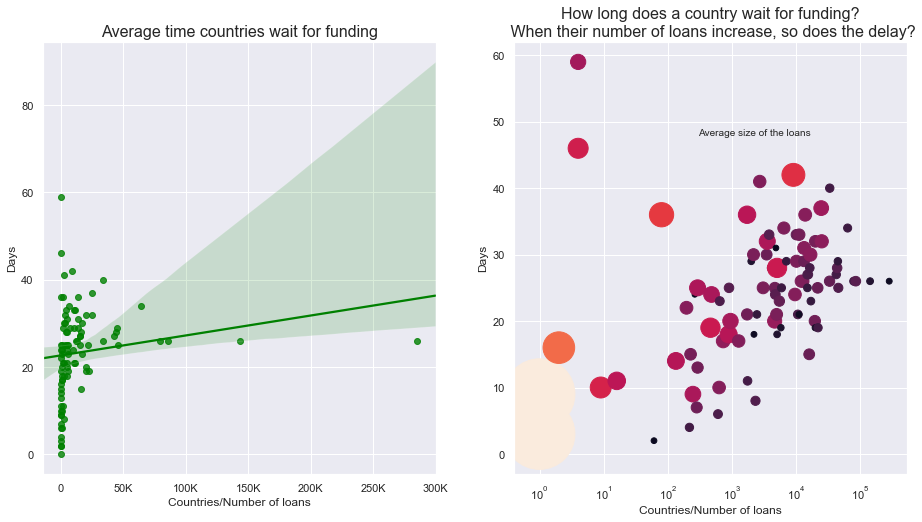

In [110]:
# create dataframe
loan_increase_time = pd.DataFrame({'countries_nr_loans': countries_nr_loans, 'avg_time_fund': avg_time_fund, 
                                   'size_loans': size_loans})

# scatter plot
plt.subplot(1, 2, 1)
# plt.scatter(countries_nr_loans, avg_time_fund)
sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time, color="green")
plt.title("Average time countries wait for funding", fontsize=16)
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000], ['0', '50K', '100K', '150K', '200K', '250K', '300K'])
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")

# scatter plot - log
plt.subplot(1, 2, 2)
plt.scatter(countries_nr_loans, avg_time_fund, s=size_loans, c=np.log10(size_loans))   
# sns.regplot(x='countries_nr_loans', y='avg_time_fund', data=loan_increase_time)
plt.text(300, 48, 'Average size of the loans')

# formatting
plt.title("How long does a country wait for funding?\n When their number of loans increase, so does the delay?", fontsize=16)
plt.xlabel("Countries/Number of loans")
plt.ylabel("Days")
plt.xscale('log') 

# plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0.2, hspace=0.4)
plt.show()

For countries with a few number of loans, the variation of average time to get the funding is significant. As soon as the number of loans start to increase, the average number of days to get the funding rapidly get close to 30, where most of them reside. 
* It seems to be that as the number of loans increases in a country, with all the remaining variables constant, so does the delay for funding a loan.

In [111]:
# pearson correlation coefficient formula
def pearson_r(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0, 1]

# observed correlation coefficient
obs_corr = pearson_r(countries_nr_loans, avg_time_fund)

print("Correlation between the number of loans and time to fund:", obs_corr)

Correlation between the number of loans and time to fund: 0.1566123458219207


Is this positive **correlation between the number of loans and time to fund significant**? I will test this assuming that there is 0 correlation between the 2 variables, leaving the time variable fixed while permuting 'countries_nr_loans'.

In [112]:
# 10000 permutations
perm_replicates = np.empty(10000)

for i in range(len(perm_replicates)):
    x_permuted = np.random.permutation(countries_nr_loans)
    perm_replicates[i] = pearson_r(x_permuted, avg_time_fund)

# p-value
p_value = np.sum(perm_replicates >= obs_corr) / len(perm_replicates)

print("p-value:", p_value)

p-value: 0.0557


Considering a significance level of 5%, we fail to reject the hypothesis that the 2 variables are independent of each other. Given this result, however, other factors such as the characteristics of each country loan could be more influential, but we will keep this in mind.

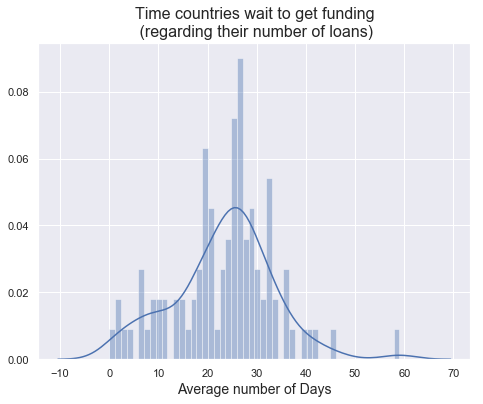

In [113]:
# histogram of the average number of days a country waits to get funding
sns.distplot(avg_time_fund, bins=50)

# formatting
plt.xlabel("Average number of Days", fontsize=14)
plt.title("Time countries wait to get funding\n (regarding their number of loans)", fontsize=16)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

Here is the distribution of the time each country waits to get funding, which was suggested on the previous display. Here, the **normal distribution** seems to fit.

In [114]:
# D'Agostino's K-squared test
stat, p_value = normaltest(avg_time_fund)
print("D'Agostino's K-squared test: statistic=%.3f; p-value=%.3f" % (stat, p_value))

D'Agostino's K-squared test: statistic=2.865; p-value=0.239


We can now see **which countries have more impact on the delay** on average and maybe get hints why.

In [115]:
# adapt index
adapt_index = list(country_loans.index)
adapt_index.remove('Virgin Islands')

# identify country and set index
loan_increase_time['country'] = adapt_index
loan_increase_time = loan_increase_time.set_index('country')

# countries with an average time to fund loans > 30
more_time = loan_increase_time.sort_values('avg_time_fund', ascending=False)
more_time_30 = more_time[more_time['avg_time_fund'] >= 30]
more_time_30

,countries_nr_loans,avg_time_fund,size_loans
country,,,
Vanuatu,4,59.0,231.2
Guam,4,46.0,400.0
United States,9125,42.0,525.3
Myanmar (Burma),2724,41.0,154.2
Colombia,33675,40.0,70.1
Paraguay,24787,37.0,217.7
Armenia,13951,36.0,164.5
Burundi,1727,36.0,303.0
Puerto Rico,80,36.0,588.3


In [116]:
# number of countries with a delay >= 30
print("number of countries with a delay higher than 30 days:", more_time_30.avg_time_fund.count())

# percentage of loans
print("% of total loans:", round(more_time_30['countries_nr_loans'].sum() / loan_increase_time['countries_nr_loans'].sum() * 100))

number of countries with a delay higher than 30 days: 22
% of total loans: 19.0


Of these, **USA, Colombia, Paraguay, Armenia, El Salvador, Lebanon, Bolivia, and Rwanda** seem to have more impact.

#####  When a loan is funded, do bigger loan amounts take more time to fund, on average?

In [117]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_3 = pd.concat([start_1, start_2], axis=0)
data_3 = data_3.set_index('loan_amount')
data_3['loan_amount'] = data_3.index

# total differences (only considering the ones which were funded)
start_1_loan = data_3[(data_3['posted_time'] < data_3['disbursed_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]
start_2_loan = data_3[(data_3['posted_time'] > data_3['disbursed_time']) & (data_3['loan_amount'] <= data_3['funded_amount'])]

# loan_time_loans 1 & 2
loan_time_1_loan = start_1_loan['funded_time'] - start_1_loan['posted_time']
loan_time_2_loan = start_2_loan['funded_time'] - start_2_loan['disbursed_time']

#concatenate
loan_time_loan_amounts = pd.concat([loan_time_1_loan.dt.days, loan_time_2_loan.dt.days], axis=0)


# create list of loan_amounts and mean time of funding
loan_amount_size = sorted(list(set(loan_time_loan_amounts.index)))
avg_time_loan = []

for i in loan_amount_size:
    avg_time_loan.append(round(loan_time_loan_amounts.loc[i].mean()))

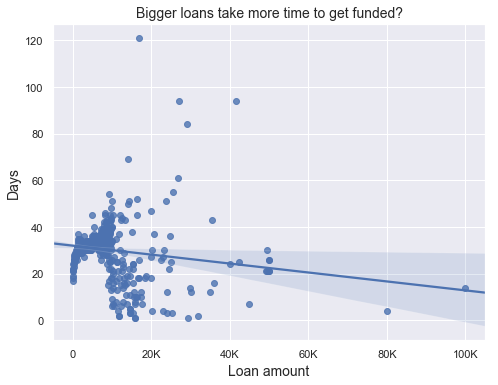

In [118]:
# create dataframe
loan_amount_time = pd.DataFrame({'loan_amount_size': loan_amount_size, 'avg_time_loan': avg_time_loan})

# scatter plot
sns.regplot(x='loan_amount_size', y='avg_time_loan', data=loan_amount_time)

# formatting
plt.title("Bigger loans take more time to get funded?", fontsize=14)
plt.xticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])
plt.xlabel("Loan amount", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [119]:
# observed correlation coefficient
obs_corr = pearson_r(loan_amount_size, avg_time_loan)

print("Correlation between loan amount and time to fund:", obs_corr)

Correlation between loan amount and time to fund: -0.1664560292672075


In [120]:
# 10000 permutations
perm_replicates = np.empty(10000)

for i in range(len(perm_replicates)):
    x_permuted = np.random.permutation(loan_amount_size)
    perm_replicates[i] = pearson_r(x_permuted, avg_time_loan)

# p-value
p_value = np.sum(perm_replicates <= obs_corr) / len(perm_replicates)

print("p-value:", p_value)

p-value: 0.0


**In general**, there is a significant negative correlation between the size of the loan and the time it takes to get funded, when considering the average time each loan size takes to get funded. We must consider the results by the number of loans for each size, though.

In [121]:
# percentage of loans smaller or equal to 5000 USD
round(data['loan_amount'].value_counts().sort_index()[:5000].sum() / data['loan_amount'].value_counts().sum(), 2)

0.99

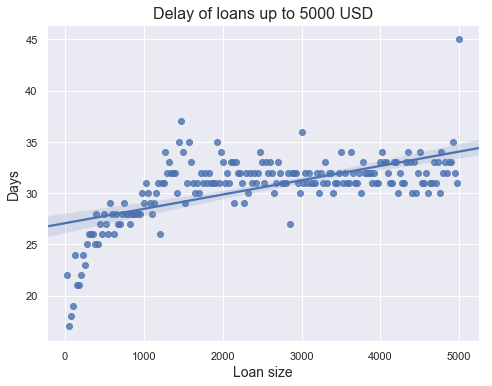

In [122]:
# size position
size_pos = loan_amount_size.index(5000)+1

# create dataframe
loan_amount_time_5000 = pd.DataFrame({'loan_amount_size_5000': loan_amount_size[:size_pos], 
                                      'avg_time_loan_5000': avg_time_loan[:size_pos]})

# scatter plot
sns.regplot(x='loan_amount_size_5000', y='avg_time_loan_5000', data=loan_amount_time_5000)

# formatting
plt.title("Delay of loans up to 5000 USD", fontsize=16)
# plt.xticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])
plt.xlabel("Loan size", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [123]:
# Correlation coefficient
obs_corr = pearson_r(loan_amount_size[:size_pos], avg_time_loan[:size_pos])

print("Correlation between loan amount (up to 5000 USD) and time to fund:", obs_corr)

Correlation between loan amount (up to 5000 USD) and time to fund: 0.6229458943939438


There is a **significative positive correlation between the loan amount and a funding delay**, up until **5000USD**, which constitutes 99% of the loans.

We notice that up until 1000USD there is an exponential increase in average delay. In fact, 77% of the loans are up to that value.

In [124]:
# percentage of loans smaller or equal to 1000 USD
round(data['loan_amount'].value_counts().sort_index()[:1000].sum() / data['loan_amount'].value_counts().sum(), 2)

0.77

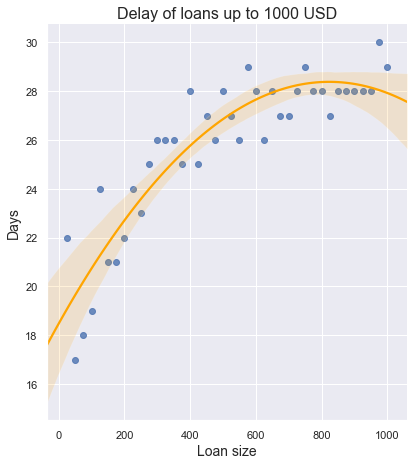

In [125]:
# size position
size_pos = loan_amount_size.index(1000)+1

# create dataframe
loan_amount_time_1000 = pd.DataFrame({'loan_amount_size_1000': loan_amount_size[:size_pos], 
                                      'avg_time_loan_1000': avg_time_loan[:size_pos]})

# scatter plot
sns.lmplot(x='loan_amount_size_1000', y='avg_time_loan_1000', data=loan_amount_time_1000, 
           order=2, line_kws={'color': 'orange'})

# formatting
plt.title("Delay of loans up to 1000 USD", fontsize=16)
# plt.xticks([0, 20000, 40000, 60000, 80000, 100000], ['0', '20K', '40K','60K', '80K', '100K'])
plt.xlabel("Loan size", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [126]:
# Correlation coefficient
obs_corr = pearson_r(loan_amount_size[:size_pos], avg_time_loan[:size_pos])

print("Correlation between loan amount (up to 1000 USD) and time to fund:", obs_corr)

Correlation between loan amount (up to 1000 USD) and time to fund: 0.8404788856034583


There is a **significative positive correlation between the loan amount and a funding delay**, up until **1000USD**, which constitutes 77% of the loans.

##### **Does the sector of the loan influences the time of funding?**

Distribution of loans among sectors

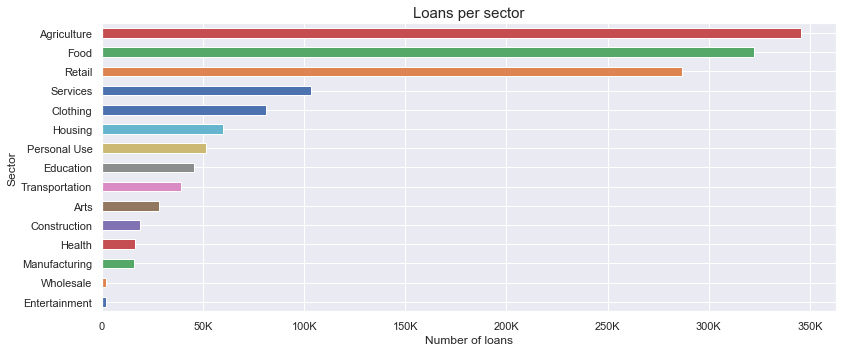

In [127]:
# quantity of loans each sector has
data['sector_name'].value_counts(ascending=True).plot(kind='barh')

# formatting
plt.title("Loans per sector", fontsize=15)
plt.xlabel("Number of loans")
plt.ylabel("Sector")
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000], 
           ["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K"])
plt.subplots_adjust(left=0, bottom=0, right=1.7, top=1, wspace=0, hspace=0.6)
plt.show()

In [128]:
# percentage of loans for the 6 main sectors
print(round(data['sector_name'].value_counts()[:6]/data['sector_name'].value_counts().sum()*100))

Agriculture    24.0
Food           23.0
Retail         20.0
Services        7.0
Clothing        6.0
Housing         4.0
Name: sector_name, dtype: float64


**67% of the loans go to 3 sectors**: Agriculture (24%), Food (23%) and Retail (20%)

In [129]:
# percentage of loans for the 6 main sectors
print(round(data['sector_name'].value_counts()[:6].sum()/data['sector_name'].value_counts().sum()*100))

85.0


**85% of the loans go to 6 sectors**: Agriculture (24%), Food (23%), Retail (20%), Services (7%), Clothing (6%) and Housing (4%).

In [130]:
# select data
data_4 = data[['sector_name', 'disbursed_time', 'posted_time', 'funded_time']]
data_4 = data_4.set_index('sector_name')

# differences
start_1_sector = data_4[data_4['posted_time'] < data_4['disbursed_time']]
start_2_sector = data_4[data_4['posted_time'] > data_4['disbursed_time']]

# sector_time 1 & 2
sector_time_1 = start_1_sector['funded_time'] - start_1_sector['posted_time']
sector_time_2 = start_2_sector['funded_time'] - start_2_sector['disbursed_time']

#concatenate
sector_time = pd.concat([sector_time_1.dt.days, sector_time_2.dt.days], axis=0)

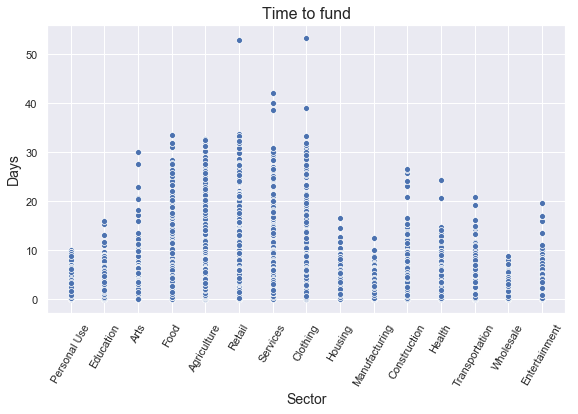

In [131]:
# create dataframe
sectors = pd.DataFrame({'sector_time': sector_time, 'sectors': sector_time.index})

# scatter plot
sns.scatterplot(x='sectors', y='sector_time', data=sectors)

# formatting
plt.title("Time to fund", fontsize=16)
plt.yticks([0, 100, 200, 300, 400, 500], ['0', '10', '20','30', '40', '50'])
plt.xlabel("Sector", fontsize=14)
plt.ylabel("Days", fontsize=14)
plt.xticks(rotation=60)

plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=0.6, hspace=0.4)
plt.show()

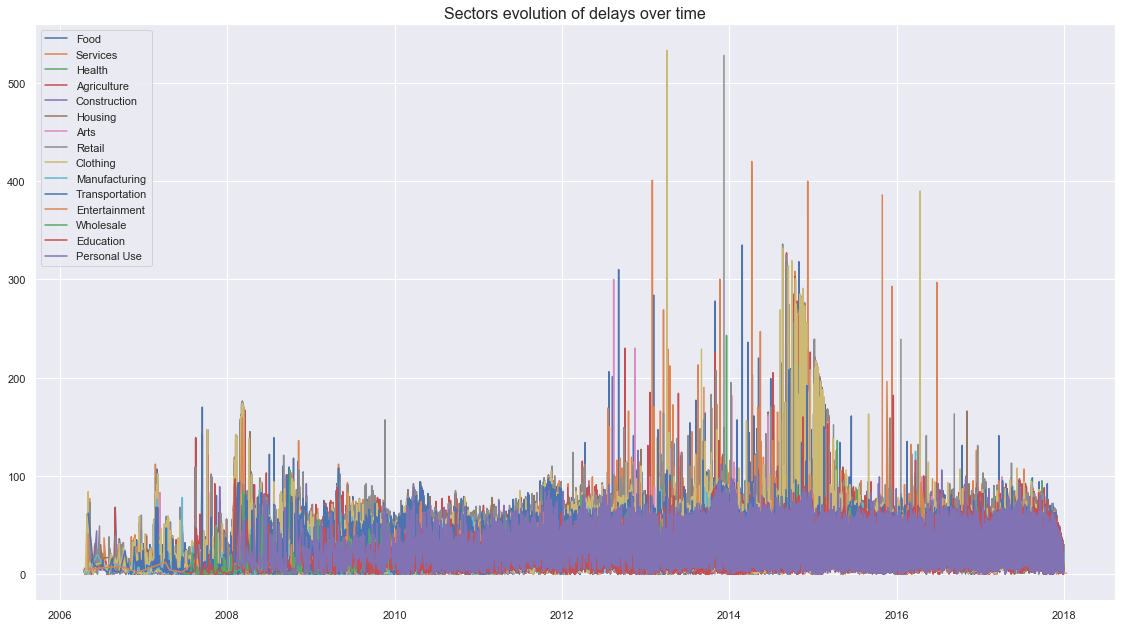

In [132]:
# sectors evolution of delays over time 

# build data frame 'sector_ordered'
sector_ordered_1 = pd.concat([start_1_sector, sector_time_1], axis=1)
sector_ordered_2 = pd.concat([start_2_sector, sector_time_2], axis=1)
sector_ordered = pd.concat([sector_ordered_1, sector_ordered_2], axis=0).drop(['disbursed_time', 'funded_time'], axis=1)
sector_ordered.columns = ['posted_time', 'delay']
sector_ordered.delay = sector_ordered.delay.dt.days
sector_ordered = sector_ordered.sort_values('posted_time')

# plot sector delays
for i in sector_ordered.index.unique():
    plt.plot(sector_ordered.loc[i]['posted_time'], sector_ordered.loc[i]['delay'])
    
plt.legend([i for i in sector_ordered.index.unique()], loc='upper left')
plt.title("Sectors evolution of delays over time", fontsize=16)
plt.subplots_adjust(left=0, bottom=-1, right=2.5, top=1, wspace=0, hspace=0)
plt.show()

The plot is not very clear, although there are some suspects, such as Clothing or Agriculture. Let us compute some statistics:

In [133]:
# sectors dataframe created
sectors.head()

,sector_time,sectors
sector_name,,
Personal Use,33.0,Personal Use
Education,2.0,Education
Arts,3.0,Arts
Personal Use,31.0,Personal Use
Food,31.0,Food


In [134]:
# sectors total loans, average and standard deviation
sector_loans = sectors.groupby('sectors').count().sector_time
perc_sector_loans = sector_loans / data['sector_name'].count()
sector_mean = sectors.groupby('sectors').mean().sector_time
sector_std = sectors.groupby('sectors').std().sector_time

# loans that take more than 30 days to fund, for sector
sector_30 = sectors[sectors['sector_time'] >= 30].groupby('sectors').count().sector_time

# For each sector, the percentage of loans >= 30 (total)
perc_30_total = sector_30 / data['sector_name'].count()

# For each sector, the percentage of loans >= 30 (sectorwise)
perc_30_sector = sector_30 / sector_loans


# dataframe with relevant information regarding sectors
sectors_2 = pd.DataFrame({'sectors': sectors.groupby('sectors').count().index, 'sector_loans': sector_loans, 
                          'perc_sector_loans': perc_sector_loans, 'sector_mean': sector_mean, 'sector_std': sector_std,
                          'sector_30': sector_30, 'perc_30_total': perc_30_total, 'perc_30_sector': perc_30_sector}).drop(
                         'sectors', axis=1)

sectors_2.sort_values('perc_30_total', ascending=False)

,sector_loans,perc_sector_loans,sector_mean,sector_std,sector_30,perc_30_total,perc_30_sector
sectors,,,,,,,
Agriculture,329198,0.231973,28.277067,17.447268,149388,0.105268,0.453794
Food,311404,0.219434,25.949850,16.178154,123813,0.087246,0.397596
Retail,272475,0.192003,27.749236,16.898185,120001,0.084560,0.440411
Services,97819,0.068929,27.082254,18.387316,40988,0.028883,0.419019
Clothing,76856,0.054157,27.084248,18.371744,32693,0.023037,0.425380
Housing,54465,0.038379,31.714771,16.587375,29752,0.020965,0.546259
Education,44772,0.031549,25.440208,13.943170,18929,0.013339,0.422787
Transportation,36433,0.025673,28.307386,17.009264,16455,0.011595,0.451651
Personal Use,49595,0.034948,21.932150,14.215565,12993,0.009156,0.261982


We can notice that **the main 5 sectors (which gather 80% of the loans) are the ones who influence the most a higher delay in fundings.**
* Agriculture has clearly the biggest impact.

##### Field partners 

In [135]:
# field partners 
fp = len(data['partner_id'].unique())
print("There are", fp, "Field partners")

There are 479 Field partners


Distribution of loans among field partners

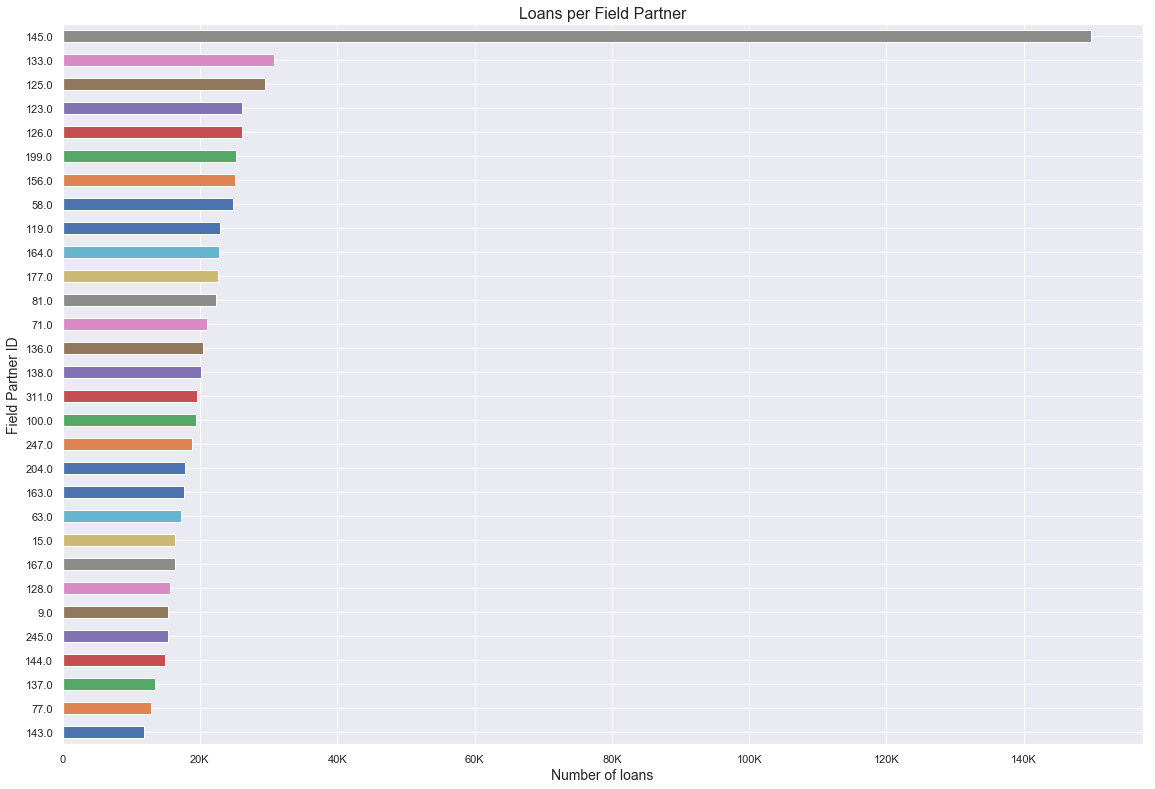

In [136]:
# quantity of loans each sector has
data['partner_id'].value_counts(ascending=True).tail(30).plot(kind='barh')

# formatting
plt.title("Loans per Field Partner", fontsize=16)
plt.xlabel("Number of loans", fontsize=14)
plt.ylabel("Field Partner ID", fontsize=14)
plt.xticks([0, 20000, 40000, 60000, 80000, 100000, 120000, 140000], ["0", "20K", "40K", "60K", "80K", "100K", "120K", "140K"])
plt.subplots_adjust(left=0, bottom=-1.5, right=2.5, top=1, wspace=0, hspace=0.6)
plt.show()

In [137]:
# field partner with more loans (id 145)
print("Partner 145 has", round(data['partner_id'].value_counts(ascending=True).tail(1).sum()/data['partner_id'].value_counts(ascending=True).sum()*100), "% of the loans")

# 120 field partners with more loans
print("The 30 field partners ( of",fp,") with more loans have", round(data['partner_id'].value_counts(ascending=True).tail(30).sum()/data['partner_id'].value_counts(ascending=True).sum()*100), "% of them")

Partner 145 has 11.0 % of the loans
The 30 field partners ( of 479 ) with more loans have 52.0 % of them


Of the **479** unique field partners, **11%** of the loans are organized by field partner nº 145, 52% by 30, and **90%** by 120 field partners.

In [138]:
#total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_5 = pd.concat([start_1, start_2], axis=0)
data_5 = data_5.set_index('partner_id')
data_5['partner_id'] = data_5.index

# total differences 
start_1_field = data_5[data_5['posted_time'] < data_5['disbursed_time']]
start_2_field = data_5[data_5['posted_time'] > data_5['disbursed_time']]

# field_time_loans 1 & 2
field_time_1_loan = start_1_field['funded_time'] - start_1_field['posted_time']
field_time_2_loan = start_2_field['funded_time'] - start_2_field['disbursed_time']

#concatenate
field_time = pd.concat([field_time_1_loan.dt.days, field_time_2_loan.dt.days], axis=0)


# create list of field partners, mean time of funding, and relative amount of loans
field_partners_ids = list(set(field_time.sort_index().index.dropna()))
avg_time_field = []
avg_field_part = []
fp_loans = []

for i in field_partners_ids:
        avg_time_field.append(round(field_time.loc[i].mean()))
        avg_field_part.append(data['partner_id'].value_counts()[i]/data['partner_id'].value_counts().sum()*100*500) 
        fp_loans.append(data['partner_id'].value_counts()[i])

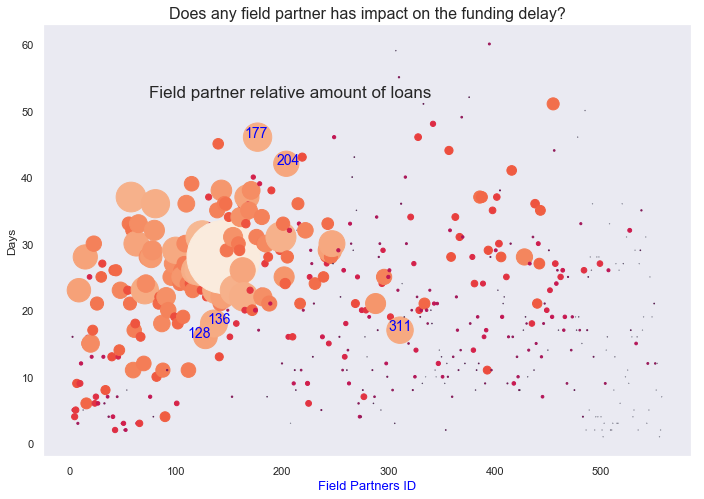

In [139]:
# create dataframe
field_partn_time = pd.DataFrame({'field_partners_ids': field_partners_ids, 'avg_time_field': avg_time_field, 'avg_field_part': avg_field_part, 'fp_loans': fp_loans})

# scatter plot
plt.scatter(field_partners_ids, avg_time_field, s=avg_field_part, c=np.log10(avg_field_part))   
plt.text(75, 52, 'Field partner relative amount of loans', fontsize=17)

# field partners of interest
plt.text(300, 17, '311', fontsize=14, color='blue') #17
plt.text(111, 16, '128', fontsize=14, color='blue') #16
plt.text(130, 18, '136', fontsize=14, color='blue') #18
plt.text(165, 46, '177', fontsize=14, color='blue') #46
plt.text(195, 42, '204', fontsize=14, color='blue') #42

# formatting
plt.title("Does any field partner has impact on the funding delay?", fontsize=16)
plt.xlabel("Field Partners ID", fontsize=13, color='blue')
plt.ylabel("Days")
plt.grid(False)

plt.subplots_adjust(left=0, bottom=-0.5, right=1.5, top=1, wspace=0.6, hspace=0.4)
plt.show()

**There are not many field partners with a considerable size of loans that affect the overall average time loans take to get funded**. Still, a few of them are relatively away from the concentrated 30-day delay.

In [140]:
# any problematic field partner?
new_fp = field_partn_time.sort_values('avg_time_field', ascending=False)
new_fp['avg_field_part'] = new_fp['avg_field_part'] / 500

# field partners that take more than 27 days on average to fund loans and with more than 1.5% of the loans
new_fp[(new_fp['avg_time_field'] >= 27) & (new_fp['avg_field_part'] >= 1.5)].sort_values('avg_time_field', ascending=False)

,field_partners_ids,avg_time_field,avg_field_part,fp_loans
156,177.0,46.0,1.610007,22582
48,58.0,37.0,1.767214,24787
68,81.0,36.0,1.592396,22335
105,125.0,31.0,2.104373,29516
171,199.0,31.0,1.805643,25326
124,145.0,28.0,10.680713,149808
113,133.0,27.0,2.192780,30756
106,126.0,27.0,1.859257,26078


Field partner with more loans, nº 145, with 11% of the loans, has an above average time to fund his loans.

##### What is the relationship between the number of lenders and the time it takes to get funding?

In [141]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_6 = pd.concat([start_1, start_2], axis=0)
data_6 = data_6.set_index('num_lenders_total')
data_6['num_lenders_total'] = data_6.index

# total differences 
start_1_numlend = data_6[(data_6['posted_time'] < data_6['disbursed_time']) & (data_6['loan_amount'] <= data_6['funded_amount'])]
start_2_numlend = data_6[(data_6['posted_time'] > data_6['disbursed_time']) & (data_6['loan_amount'] <= data_6['funded_amount'])]

# loan_time_numlend 1 & 2
loan_time_1_numlend = start_1_numlend['funded_time'] - start_1_numlend['posted_time']
loan_time_2_numlend = start_2_numlend['funded_time'] - start_2_numlend['disbursed_time']

#concatenate
loan_time_numlend = pd.concat([loan_time_1_numlend.dt.days, loan_time_2_numlend.dt.days], axis=0)

# create list of loan_numlend and mean time of funding
loan_numlend = sorted(list(set(loan_time_numlend.index)))
avg_time_numlend = []

for i in loan_numlend:
    avg_time_numlend.append(round(loan_time_numlend.loc[i].mean()))

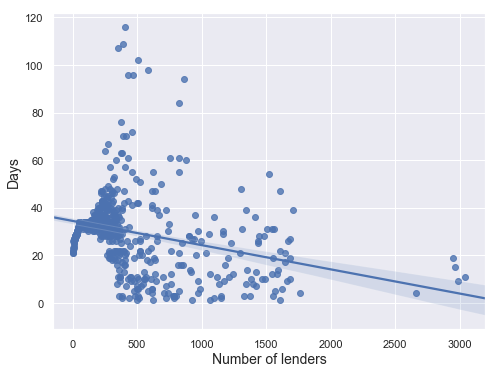

In [142]:
# create dataframe
loan_numlend_time = pd.DataFrame({'loan_numlend': loan_numlend, 'avg_time_numlend': avg_time_numlend})

# scatter plot
sns.regplot(x='loan_numlend', y='avg_time_numlend', data=loan_numlend_time)

# formatting
# plt.title("Less time to fund when more lenders come in", fontsize=16)
plt.xlabel("Number of lenders", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

Globally, as the number of lenders increased, the average number of days to fund a loan decreased. However, we should also look at what percentage of the total loans each dot (number of lenders) have.

Looking at the relationship between the number of loans per number of lenders.

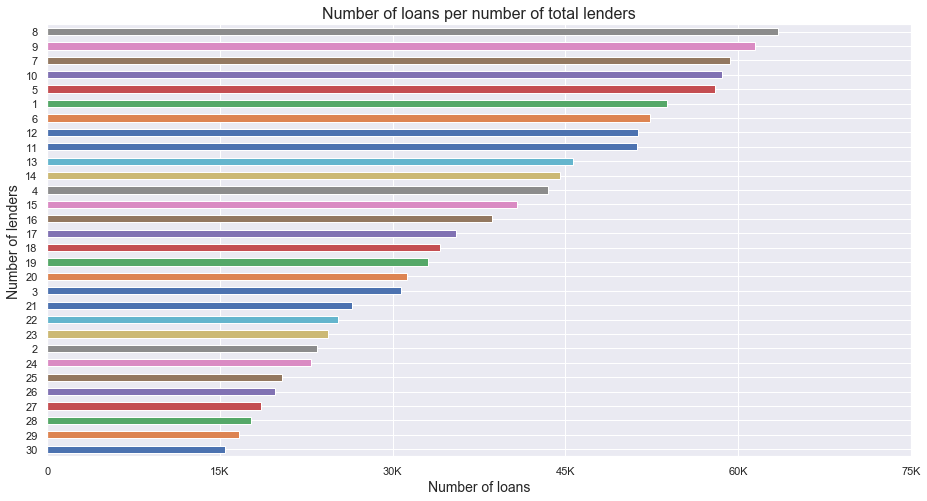

In [143]:
# number of loans per total number of lenders
data['num_lenders_total'].value_counts(ascending=True).tail(30).plot(kind='barh')

# formatting
plt.title("Number of loans per number of total lenders", fontsize=16)
plt.xlabel("Number of loans", fontsize=14)
plt.ylabel("Number of lenders", fontsize=14)
plt.xticks([0, 15000, 30000, 45000, 60000, 75000], ["0", "15K", "30K", "45K", "60K", "75K"])
plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

In [144]:
# percentage of total loans that the 60 highest number of loans per number of lenders
data['num_lenders_total'].value_counts(ascending=True).tail(60).sum()/len(data['num_lenders_total'])*100

93.80166046330055

94% of the loans are composed by up to 60 lenders. 

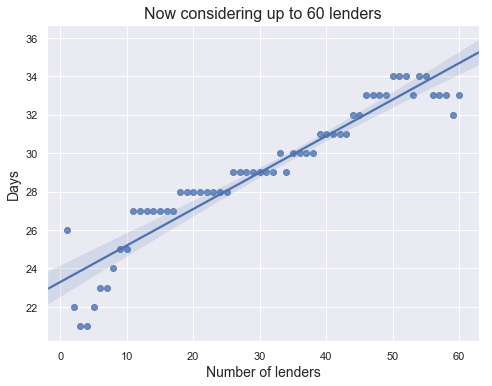

In [145]:
# create dataframe
loan_numlend_time_60 = pd.DataFrame({'loan_numlend_60': loan_numlend[:60], 'avg_time_numlend_60': avg_time_numlend[:60]})

# scatter plot
sns.regplot(x='loan_numlend_60', y='avg_time_numlend_60', data=loan_numlend_time_60)

# formatting
plt.title("Now considering up to 60 lenders", fontsize=16)
plt.xlabel("Number of lenders", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [146]:
# Correlation coefficient
pearson_r(loan_numlend[:60], avg_time_numlend[:60])

0.9487753506069476

This seemingly organized disposition could suggest that the time to disburse and fund a loan is not subject to much uncertainty, in the sense that field partners may do prearranged commitments to fund the loans.

##### Does repayment interval affect delay?

In [147]:
# number of loans per repayment interval
data['repayment_interval'].value_counts()

monthly      777963
irregular    529444
bullet       111093
weekly          622
Name: repayment_interval, dtype: int64

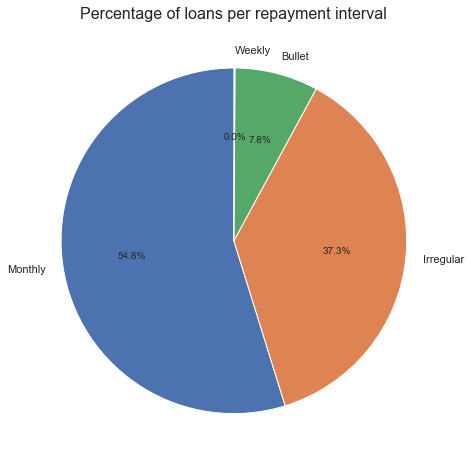

In [148]:
# define sizes
size_monthly = round(data['repayment_interval'].value_counts()[0]/data['repayment_interval'].value_counts().sum(), 3)
size_irregular = round(data['repayment_interval'].value_counts()[1]/data['repayment_interval'].value_counts().sum(), 3)
size_bullet = round(data['repayment_interval'].value_counts()[2]/data['repayment_interval'].value_counts().sum(), 3)
size_weekly = round(data['repayment_interval'].value_counts()[3]/data['repayment_interval'].value_counts().sum(), 3)

# formatting
labels = ["Monthly", "Irregular", "Bullet", "Weekly"]
sizes = [size_monthly, size_irregular, size_bullet, size_weekly]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of loans per repayment interval", fontsize=16)
plt.ylabel("")

plt.subplots_adjust(left=0, bottom=-0.5, right=1, top=1, wspace=0, hspace=0)
plt.show()

In [149]:
#total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# select data
data_7 = pd.concat([start_1, start_2], axis=0)
data_7 = data_7.set_index('repayment_interval')
data_7['repayment_interval'] = data_7.index

# total differences 
start_1_repay = data_7[data_7['posted_time'] < data_7['disbursed_time']]
start_2_repay = data_7[data_7['posted_time'] > data_7['disbursed_time']]

# repay_time_loans 1 & 2
repay_time_1_loan = start_1_repay['funded_time'] - start_1_repay['posted_time']
repay_time_2_loan = start_2_repay['funded_time'] - start_2_repay['disbursed_time']

#concatenate
repay_time = pd.concat([repay_time_1_loan.dt.days, repay_time_2_loan.dt.days], axis=0)

# create list of repayment intervals, mean time of funding, and relative amount of loans
repay_intervals = list(set(repay_time.index))
avg_time_repay = []

for i in repay_intervals:
        avg_time_repay.append(round(repay_time.loc[i].mean()))  

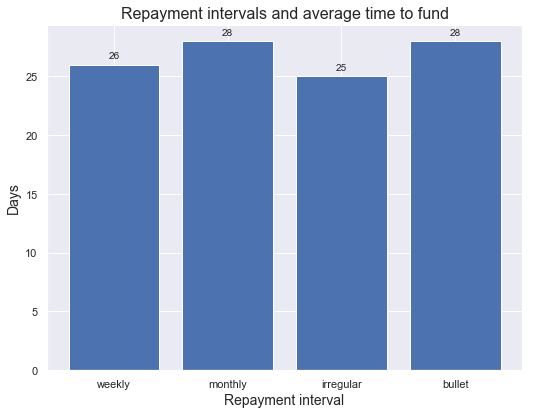

In [150]:
# repayment interval average time to fund
plt.bar(repay_intervals, avg_time_repay)

# formatting
plt.title("Repayment intervals and average time to fund", fontsize=16)
plt.xlabel("Repayment interval", fontsize=14)
plt.ylabel("Days", fontsize=14)

for x, y in zip(repay_intervals, avg_time_repay):
    plt.annotate("%i" % y, (x, y + 0.5), ha='center')

plt.subplots_adjust(left=0, bottom=-0.2, right=1.1, top=1, wspace=0, hspace=0)
plt.show()

In [151]:
print("Weekly repayments standard deviation:", round(repay_time.loc['weekly'].std()))
print("Bullet repayments standard deviation:",round(repay_time.loc['bullet'].std()))
print("Monthly repayments standard deviation:",round(repay_time.loc['monthly'].std()))
print("Irregular repayments standard deviation:",round(repay_time.loc['irregular'].std()))

Weekly repayments standard deviation: 26
Bullet repayments standard deviation: 18
Monthly repayments standard deviation: 19
Irregular repayments standard deviation: 14


It seems that **irregular repayments behave better than monthly repayments**.

**Is there a significant difference?**

To test this, I am going to divide the data into 2 parts: below the median and above the median of the time to fund a loan. I will then perform a chi-square test.

- Null hypothesis: *"the type of repayment interval does not affect delays"*
- Alternate hypothesis: *"the type of repayment interval does affect delays"*

In [152]:
# time to fund
loan_time.describe().apply(lambda x: format(x, 'f'))

count    1354847.000000
mean          26.995140
std           16.891946
min            0.000000
25%           14.000000
50%           26.000000
75%           36.000000
max          533.000000
dtype: object

In [153]:
# subsets
above_median = data.loc[loan_time[loan_time >= loan_time.median()].index]
below_median = data.loc[loan_time[loan_time < loan_time.median()].index]

In [154]:
# repayment intervals
repay_intervals

# function for counting the number of repayment intervals
def count_rep(rep, df):
    count = df['repayment_interval'].value_counts()[rep]
    return count

# function for computing the proportion
def prop_rep(rep, df):
    prop = df['repayment_interval'].value_counts()[rep] / len(df)
    return prop

# observed and expected values
observed_values = []
expected_values = []

for i in repay_intervals:
    observed_values.append(count_rep(i, above_median))
    expected_values.append(prop_rep(i, below_median))

expected_values = [round(x * len(above_median)) for x in expected_values]

print("Repayment intervals:", repay_intervals)
print("Observed values above the median:", observed_values)
print("Expected values above the median:", expected_values)

print("chi-square test:", scipy.stats.chisquare(observed_values, expected_values))


Repayment intervals: ['weekly', 'monthly', 'irregular', 'bullet']
Observed values above the median: [253, 389123, 258350, 54848]
Expected values above the median: [397.0, 370378.0, 283400.0, 48398.0]
chi-square test: Power_divergenceResult(statistic=4074.7097870097173, pvalue=0.0)


We then reject the hypothesis that the type of repayment interval does not have effect on the delay in funding. **There is a significant difference**. After this, it is not a huge step to say that all in all irregular repayments have a significant better performance than monthly repayments, regarding delays.

##### When the loan is not completely funded, how big  it is?

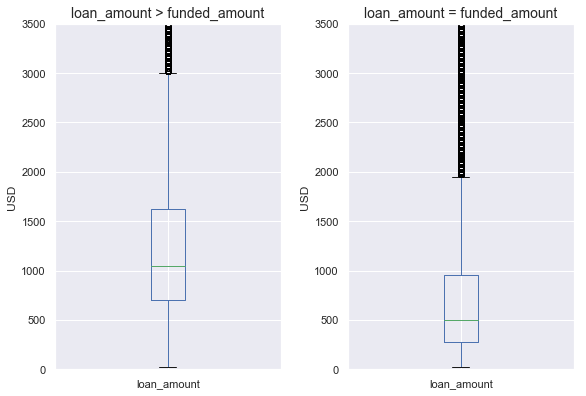

In [155]:
# loan_amount > funded_amount
plt.subplot(1, 2, 1)
data[data['loan_amount'] > data['funded_amount']].loan_amount.plot(kind='box')
plt.title("loan_amount > funded_amount", fontsize=14)
plt.ylabel("USD")
plt.ylim(0, 3500)

# loan_amount = funded_amount
plt.subplot(1, 2, 2)
data[data['loan_amount'] == data['funded_amount']].loan_amount.plot(kind='box')
plt.title("loan_amount = funded_amount", fontsize=14)
plt.ylabel("USD")
plt.ylim(0, 3500)

plt.subplots_adjust(left=0, bottom=-0.2, right=1.2, top=1, wspace=0.3, hspace=0.4)
plt.show()

They are bigger than usual, as expected.

## Extra data wrangling and EDA

**Building the new dataframe** for modeling:

In [156]:
# total differences
start_1 = data[data['posted_time'] < data['disbursed_time']]
start_2 = data[data['posted_time'] > data['disbursed_time']]

# loan time 1 & 2
loan_time_1 = start_1['funded_time'] - start_1['posted_time']
loan_time_2 = start_2['funded_time'] - start_2['disbursed_time']

#concatenate
real_time = pd.concat([loan_time_1, loan_time_2], axis=0)#dt.days

# new dataframe to deal with
new_df = pd.concat([start_1, start_2], axis=0)

# add the time to fund the loan
new_df['real_time'] = real_time

# order by date
new_df = new_df.sort_values('posted_time')

###################### (pause) ###########################################################

Before continuing the rearrangement of the new dataframe, let's use this new_df and do **some more EDA**.

**Does lender term influence delay?**

In [157]:
new_df[new_df.lender_term.isna()].shape

(23, 22)

Since there are only 23 missing values in the lender_term column, I will opt to delete them.

In [158]:
# index values
lender_term_delete = new_df[new_df.lender_term.isna()].index

# remove rows
new_df = new_df.drop(lender_term_delete)

# new shape
new_df.shape

(1416557, 22)

Let us now look at the relationship between the lender term length and its average delay

In [159]:
# create array of unique lender terms and compute their mean delay
set_lender_terms = new_df.lender_term.unique()
avg_time_lender_term = []

for i in set_lender_terms:
    avg_time_lender_term.append(new_df[new_df['lender_term'] == i].real_time.dt.days.mean())

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


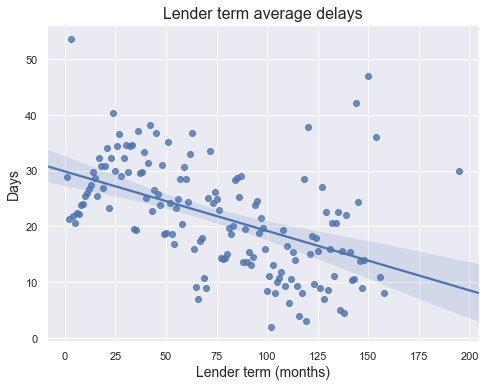

In [160]:
# create dataframe
time_lender_term = pd.DataFrame({'lender_term_i': set_lender_terms, 'avg_time_lender_term': avg_time_lender_term})

# scatter plot
sns.regplot(x='lender_term_i', y='avg_time_lender_term', data=time_lender_term)

# formatting
plt.title("Lender term average delays", fontsize=16)
plt.xlabel("Lender term (months)", fontsize=14)
plt.ylabel("Days", fontsize=14)

plt.subplots_adjust(left=0, bottom=-0.1, right=1, top=1, wspace=0.6, hspace=0.4)
plt.show()

In [161]:
# correlation
print("Correlation between lender term (months) and delay: {}".format(pearson_r(set_lender_terms, avg_time_lender_term)))

Correlation between lender term (months) and delay: -0.4954661735046612


As expected, the longer the lender term, the stronger the possibility that there is a smaller delay, on average.

**Currency**

In [162]:
# percentage of loans by currency
nr_currencies = 20

# n largest currencies
print("Total percentage of loans by the {} largest currencies: {}".format(
    nr_currencies,
    new_df.currency.value_counts()[:nr_currencies].sum() / new_df.currency.value_counts().sum()))

# 3 largest currencies
print("Total percentage of loans by the 3 largest currencies: {}".format(
    new_df.currency.value_counts()[:3].sum() / new_df.currency.value_counts().sum()))

Total percentage of loans by the 20 largest currencies: 0.8534700686241359
Total percentage of loans by the 3 largest currencies: 0.4695497604402788


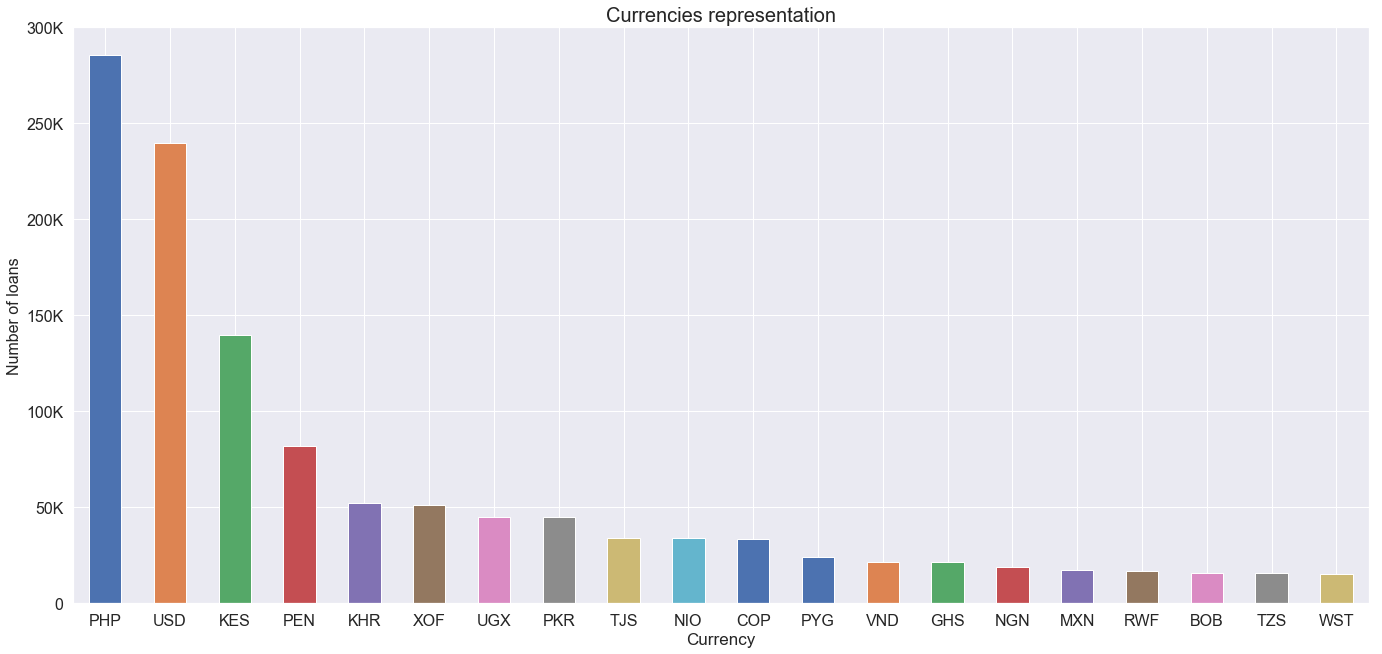

In [163]:
# bar plot
new_df.currency.value_counts()[:nr_currencies].plot(kind='bar')

# formatting
plt.title("Currencies representation", fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.xlabel("Currency", fontsize=17)
plt.ylabel("Number of loans", fontsize=16)
plt.yticks([0, 50000, 100000, 150000, 200000, 250000, 300000], 
           ['0', '50K', '100K','150K', '200K', '250K', '300K'], fontsize=16)

plt.subplots_adjust(left=0, bottom=-1, right=3, top=1, wspace=0, hspace=0)
plt.show()

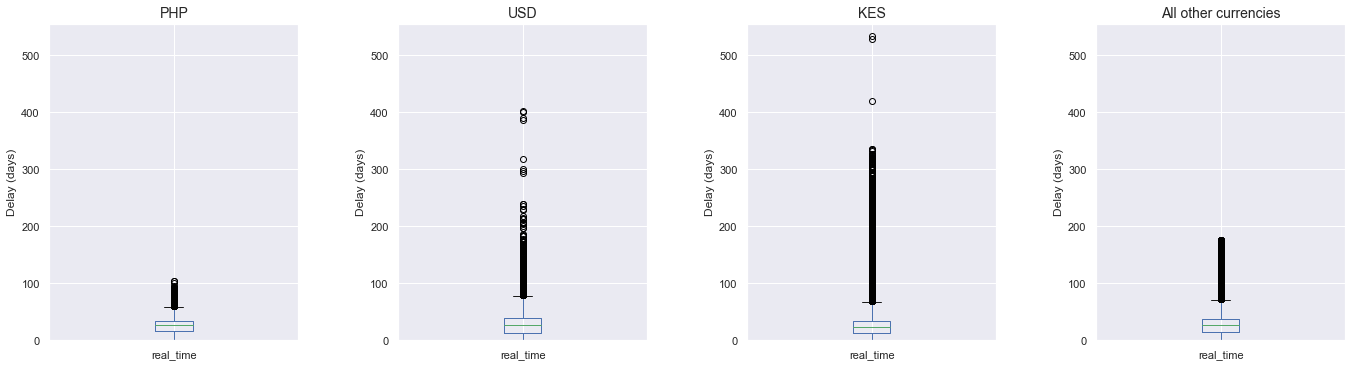

In [164]:
# currency characteristics
currencies_3 = ['PHP', 'USD', 'KES']
    
# boxplots
for i, j in enumerate(currencies_3):
    plt.subplot(1, 4, i+1)
    new_df[new_df['currency'] == j].real_time.dt.days.plot(kind='box')
    plt.title(j, fontsize=14)
    plt.ylabel("Delay (days)")
    plt.ylim(0, 555)
        
# dataframe for the other currencies
curr_df = new_df[~new_df['currency'].isin(currencies_3)]

plt.subplot(1, 4, 4)
curr_df.real_time.dt.days.plot(kind='box')
plt.title("All other currencies", fontsize=14)
plt.ylabel("Delay (days)")
plt.ylim(0, 555)

plt.subplots_adjust(left=0, bottom=-0.1, right=3, top=1, wspace=0.4, hspace=0.5)
plt.show()    

Now with a zoom excluding outliers:

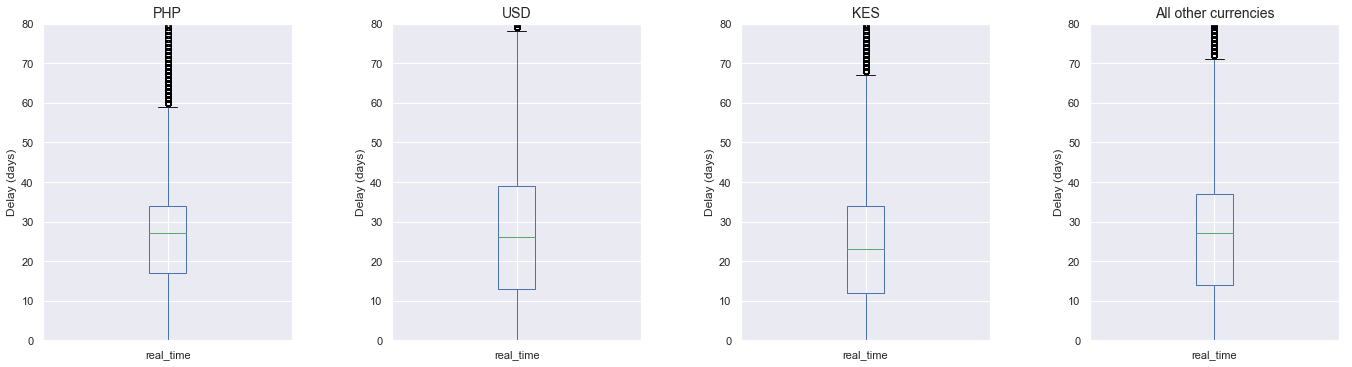

In [165]:
# currency characteristics
currencies_3 = ['PHP', 'USD', 'KES']
    
# boxplots
for i, j in enumerate(currencies_3):
    plt.subplot(1, 4, i+1)
    new_df[new_df['currency'] == j].real_time.dt.days.plot(kind='box')
    plt.title(j, fontsize=14)
    plt.ylabel("Delay (days)")
    plt.ylim(0, 80)
        
# dataframe for the other currencies
curr_df = new_df[~new_df['currency'].isin(currencies_3)]

plt.subplot(1, 4, 4)
curr_df.real_time.dt.days.plot(kind='box')
plt.title("All other currencies", fontsize=14)
plt.ylabel("Delay (days)")
plt.ylim(0, 80)

plt.subplots_adjust(left=0, bottom=-0.1, right=3, top=1, wspace=0.4, hspace=0.5)
plt.show()    

We see that **USD** is probably the currency that contributes more to delay in loans.

##### Currency policy

Currency policy can be of 2 kinds: shared or not shared. Kiva Field Partners have the choice to "opt-in" to Currency Risk Protection, which means they can choose to manage all Foreign Exchange Risk themselves, or alternatively they pass on the risk of currency devaluation over 20% to Kiva Lenders.

In [166]:
new_df.currency_policy.value_counts()

shared        1098062
not shared     318495
Name: currency_policy, dtype: int64

In [167]:
# percentage-wise
print("Shared: {0:.0%}".format(new_df.currency_policy.value_counts()[0]/new_df.currency_policy.value_counts().sum()))
print("Not shared: {0:.0%}".format(new_df.currency_policy.value_counts()[1]/new_df.currency_policy.value_counts().sum()))

Shared: 78%
Not shared: 22%


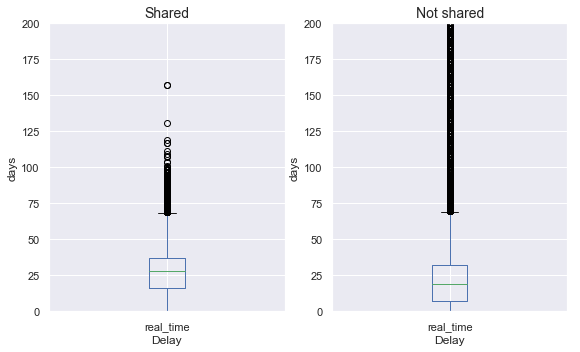

In [168]:
# plot differences in delay (shared)
plt.subplot(1, 2, 1)
new_df[new_df['currency_policy'] == 'shared'].real_time.dt.days.plot(kind='box')
plt.title("Shared", fontsize=14)
plt.xlabel("Delay")
plt.ylabel("days")
plt.ylim(0, 200)

# plot differences in delay (not shared)
plt.subplot(1, 2, 2)
new_df[new_df['currency_policy'] == 'not shared'].real_time.dt.days.plot(kind='box')
plt.title("Not shared", fontsize=14)
plt.xlabel("Delay")
plt.ylabel("days")
plt.ylim(0, 200)

plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=0.2, hspace=0.4)
plt.show()

A not shared currency policy has the more problematic cases, as expected, as there are a lot more (long-time) outliers. However, overall, have a smaller median and general statistic properties than loans with a currency shared policy.

In [169]:
# status of the shared currency policy cases
new_df[new_df['currency_policy'] == 'shared'].status.value_counts()

funded         1041630
expired          49841
fundRaising       3397
refunded          3194
Name: status, dtype: int64

In [170]:
# status of the not shared currency policy cases
new_df[new_df['currency_policy'] == 'not shared'].status.value_counts()

funded         308443
expired          6962
refunded         2931
fundRaising       159
Name: status, dtype: int64

**In general, how does the delay behaves over time?**

General presentation of the real time to fund a loan over time and its trend:

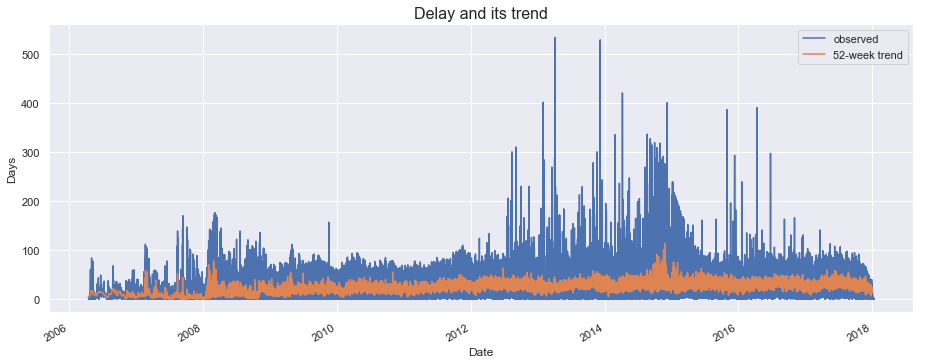

In [171]:
# delays dataframe
delays = pd.DataFrame({'real_time': new_df['real_time'].dt.days, 'time': new_df['posted_time']}).dropna()
delays.set_index('time', inplace=True)

# decomposition
decomposition = sm.tsa.seasonal_decompose(delays['real_time'], freq=52)

decomposition.observed.plot()
decomposition.trend.plot()

plt.title("")
plt.legend(['observed', '52-week trend'])

plt.xlabel("Date")
plt.ylabel("Days")
plt.title("Delay and its trend", fontsize=16)
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

As we can see, there is a tendency to increase the fund delay over time. Looking more closely at the 52-week trend:

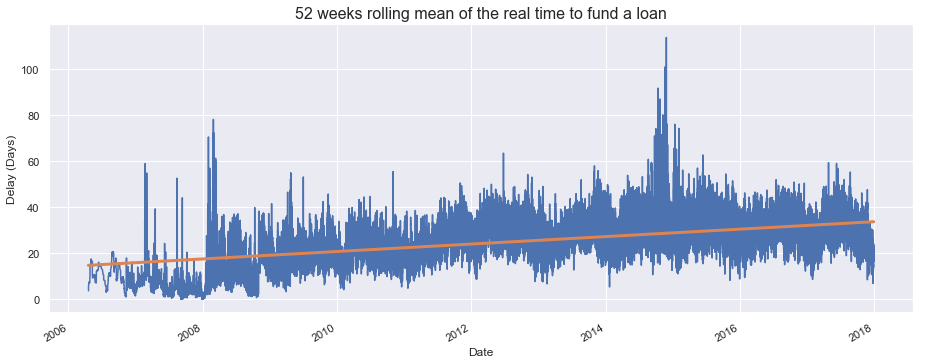

In [172]:
# 52 weeks rolling mean of the real time to fund a loan [decomposition trend (freq=52)]
decomposition.trend.plot()

# regression line
ordinals_dec = [i.toordinal() for i in decomposition.trend.dropna().index]

a, b = np.polyfit(ordinals_dec, decomposition.trend.dropna(), 1)
x = np.array([min(ordinals_dec), max(ordinals_dec)])
y = a * x + b
plt.plot(x, y, linewidth=3)

# formatting
plt.title("52 weeks rolling mean of the real time to fund a loan", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Delay (Days)")
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

As we can see in the 52-week trend, **the delays are increasing, on average, over time**. 

**Preparing the dataset for modeling analysis:**

We will select only certain columns of interest, and exclude all the rows where a computation of the real time of delay was not possible. These don't affect the previous EDA made. 

We will not consider the following variables:
* ['loan_id', 'funded_amount', 'status', 'activity_name', 'loan_use', 'country_code', 'town_name', 'posted_time', 'planned_expiration_time', 'disbursed_time', 'funded_time', 'borrower_genders']

They are either not necessary or do not possess suficient quality data in order to be considered.

In [173]:
# rows excluded
print("Number of real_time missing values excluded: {}".format(new_df[new_df.real_time.isna()].count().posted_time))

Number of real_time missing values excluded: 61732


In [174]:
# excluding them
missing_real_time = new_df[new_df.real_time.isna()].index

new_df = new_df.drop(missing_real_time)

# new shape
new_df.shape

(1354825, 22)

In [175]:
# rearrange new_df with only the columns of interest
col_interest = ['real_time', 'loan_amount', 'sector_name', 'country_name', 'currency_policy',
               'currency', 'partner_id', 'lender_term', 'num_lenders_total', 'repayment_interval']

new_df = new_df[col_interest]

# new shape
new_df.shape

(1354825, 10)

In [176]:
# info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354825 entries, 1408669 to 780093
Data columns (total 10 columns):
real_time             1354825 non-null timedelta64[ns]
loan_amount           1354825 non-null float64
sector_name           1354825 non-null object
country_name          1354825 non-null object
currency_policy       1354825 non-null object
currency              1354825 non-null object
partner_id            1340846 non-null float64
lender_term           1354825 non-null float64
num_lenders_total     1354825 non-null int64
repayment_interval    1354825 non-null object
dtypes: float64(3), int64(1), object(5), timedelta64[ns](1)
memory usage: 113.7+ MB


We have missing data on the partner_id column, which represents individuals, that is, not a Kiva partner. Therefore, I will replace the missing values with 1.

In [177]:
# partner_id values
new_df['partner_id'].sort_values().unique()

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  13.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  30.,  31.,  32.,  33.,  34.,  36.,  37.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  70.,  71.,  72.,  73.,  74.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  84.,  85.,  87.,  88.,  90.,  91.,  92.,
        93.,  96.,  97.,  98.,  99., 100., 101., 102., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       164., 165., 166., 167., 168., 169., 170., 17

In [178]:
# replace NaN's with 1 (individuals)
new_df.partner_id.fillna(1, inplace=True)

In [179]:
# reset index
new_df_2 = new_df.copy()
new_df_2 = new_df_2.reset_index(drop=True)

# changing real_time variable to numeric 
new_df_2['real_time'] = new_df_2['real_time'].dt.days

# changing dtype of partner_id
new_df_2['partner_id'] = new_df_2['partner_id'].astype('category')

# head
new_df_2.head()

,real_time,loan_amount,sector_name,country_name,currency_policy,currency,partner_id,lender_term,num_lenders_total,repayment_interval
0,3,700.0,Food,Cambodia,not shared,USD,9.0,10.0,15,bullet
1,4,1000.0,Services,Cambodia,not shared,USD,9.0,12.0,15,bullet
2,4,1600.0,Health,Cambodia,not shared,USD,9.0,18.0,18,bullet
3,1,600.0,Agriculture,Kenya,not shared,USD,6.0,15.0,6,monthly
4,6,450.0,Construction,Uganda,not shared,USD,8.0,9.0,10,irregular


We now need to transform all categorical variables to numbers and stay with those only.

In [180]:
# final data frame
final_df = pd.get_dummies(new_df_2)

# head
final_df.head()

,real_time,loan_amount,lender_term,num_lenders_total,sector_name_Agriculture,sector_name_Arts,sector_name_Clothing,sector_name_Construction,sector_name_Education,sector_name_Entertainment,...,partner_id_551.0,partner_id_552.0,partner_id_553.0,partner_id_555.0,partner_id_556.0,partner_id_557.0,repayment_interval_bullet,repayment_interval_irregular,repayment_interval_monthly,repayment_interval_weekly
0,3,700.0,10.0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4,1000.0,12.0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,4,1600.0,18.0,18,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,600.0,15.0,6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,6,450.0,9.0,10,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## 3) Machine Learning

In [181]:
machine learning

SyntaxError: invalid syntax (<ipython-input-181-6ba2dd2f3e99>, line 1)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
%%time

# preparing target and data values
y = final_df['real_time'].values
X = final_df.drop('real_time', axis=1).values

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=3)

# Instantiate a DecisionTreeRegressor 'dt'
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=1)
# min_samples_leaf=0.1 ---> impose condition in which each leaf has to contain at least 10% of the training data

# Fit 'dt' to the training-set
dt.fit(X_train, y_train)

# Predict test-set labels
y_pred = dt.predict(X_test)

# Compute test-set RMSE 
rmse_dt = MSE(y_test, y_pred) ** (1/2)

print("Mean squared error (MSE):", rmse_dt)